In [1]:
import math
import torch
import gpytorch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import trange, tqdm_notebook
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_excel('points.xlsx')

In [3]:
data.head()

,Shear rate,ppm,Viscosity
0,7.835758,10,1.683102
1,12.762008,10,1.486875
2,20.587486,10,1.414947
3,33.530600,10,1.380299
4,54.610900,10,1.313526


In [4]:
x = data.drop('Viscosity', axis=1).values
y = data.Viscosity.values

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)

In [6]:
train_x = torch.tensor(x_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)
test_x = torch.tensor(x_test, dtype=torch.float32)
test_y = torch.tensor(y_test, dtype=torch.float32)

In [14]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [15]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 1000
for i in trange(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.log_lengthscale.item(),
        model.likelihood.log_noise.item()
    ))
    optimizer.step()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Iter 1/1000 - Loss: 255819.734   log_lengthscale: -0.367   log_noise: -0.367
Iter 2/1000 - Loss: 237379.516   log_lengthscale: -0.295   log_noise: -0.295
Iter 3/1000 - Loss: 243215.391   log_lengthscale: -0.227   log_noise: -0.226
Iter 4/1000 - Loss: 227981.453   log_lengthscale: -0.169   log_noise: -0.158
Iter 5/1000 - Loss: 213888.875   log_lengthscale: -0.187   log_noise: -0.091


  0%|▍                                                                                | 5/1000 [00:00<00:21, 46.42it/s]

Iter 6/1000 - Loss: 200066.891   log_lengthscale: -0.217   log_noise: -0.026
Iter 7/1000 - Loss: 171278.906   log_lengthscale: -0.251   log_noise: 0.036
Iter 8/1000 - Loss: 160457.812   log_lengthscale: -0.283   log_noise: 0.095
Iter 9/1000 - Loss: 151983.141   log_lengthscale: -0.309   log_noise: 0.151
Iter 10/1000 - Loss: 144703.984   log_lengthscale: -0.328   log_noise: 0.204


  1%|▊                                                                               | 10/1000 [00:00<00:21, 46.94it/s]

Iter 11/1000 - Loss: 143574.734   log_lengthscale: -0.347   log_noise: 0.254
Iter 12/1000 - Loss: 131790.625   log_lengthscale: -0.362   log_noise: 0.302
Iter 13/1000 - Loss: 125952.039   log_lengthscale: -0.377   log_noise: 0.348
Iter 14/1000 - Loss: 120058.430   log_lengthscale: -0.386   log_noise: 0.391
Iter 15/1000 - Loss: 120938.242   log_lengthscale: -0.397   log_noise: 0.431


  2%|█▏                                                                              | 15/1000 [00:00<00:20, 47.18it/s]

Iter 16/1000 - Loss: 111041.734   log_lengthscale: -0.406   log_noise: 0.471
Iter 17/1000 - Loss: 112180.867   log_lengthscale: -0.415   log_noise: 0.509
Iter 18/1000 - Loss: 102787.406   log_lengthscale: -0.428   log_noise: 0.545
Iter 19/1000 - Loss: 104049.914   log_lengthscale: -0.440   log_noise: 0.579
Iter 20/1000 - Loss: 96353.430   log_lengthscale: -0.443   log_noise: 0.612


  2%|█▌                                                                              | 20/1000 [00:00<00:21, 46.43it/s]

Iter 21/1000 - Loss: 93133.945   log_lengthscale: -0.443   log_noise: 0.643
Iter 22/1000 - Loss: 115030.211   log_lengthscale: -0.453   log_noise: 0.672
Iter 23/1000 - Loss: 88249.766   log_lengthscale: -0.476   log_noise: 0.703
Iter 24/1000 - Loss: 94656.758   log_lengthscale: -0.501   log_noise: 0.731
Iter 25/1000 - Loss: 92302.672   log_lengthscale: -0.526   log_noise: 0.758


  2%|██                                                                              | 25/1000 [00:00<00:21, 45.92it/s]

Iter 26/1000 - Loss: 89804.547   log_lengthscale: -0.560   log_noise: 0.785
Iter 27/1000 - Loss: 81385.031   log_lengthscale: -0.602   log_noise: 0.810
Iter 28/1000 - Loss: 79727.492   log_lengthscale: -0.642   log_noise: 0.833
Iter 29/1000 - Loss: 77952.578   log_lengthscale: -0.677   log_noise: 0.856
Iter 30/1000 - Loss: 76668.617   log_lengthscale: -0.703   log_noise: 0.877


  3%|██▍                                                                             | 30/1000 [00:00<00:21, 44.83it/s]

Iter 31/1000 - Loss: 81374.430   log_lengthscale: -0.739   log_noise: 0.897
Iter 32/1000 - Loss: 73985.469   log_lengthscale: -0.769   log_noise: 0.917
Iter 33/1000 - Loss: 72302.914   log_lengthscale: -0.798   log_noise: 0.935
Iter 34/1000 - Loss: 77520.805   log_lengthscale: -0.818   log_noise: 0.953
Iter 35/1000 - Loss: 86273.570   log_lengthscale: -0.851   log_noise: 0.971


  4%|██▊                                                                             | 35/1000 [00:00<00:21, 44.33it/s]

Iter 36/1000 - Loss: 74766.070   log_lengthscale: -0.882   log_noise: 0.989
Iter 37/1000 - Loss: 68735.227   log_lengthscale: -0.929   log_noise: 1.007
Iter 38/1000 - Loss: 68261.797   log_lengthscale: -0.975   log_noise: 1.024
Iter 39/1000 - Loss: 66818.133   log_lengthscale: -1.012   log_noise: 1.040
Iter 40/1000 - Loss: 66069.375   log_lengthscale: -1.056   log_noise: 1.055


  4%|███▏                                                                            | 40/1000 [00:00<00:21, 43.65it/s]

Iter 41/1000 - Loss: 65787.125   log_lengthscale: -1.086   log_noise: 1.069
Iter 42/1000 - Loss: 64211.652   log_lengthscale: -1.101   log_noise: 1.083
Iter 43/1000 - Loss: 68925.727   log_lengthscale: -1.113   log_noise: 1.096
Iter 44/1000 - Loss: 60390.301   log_lengthscale: -1.107   log_noise: 1.110
Iter 45/1000 - Loss: 61799.461   log_lengthscale: -1.115   log_noise: 1.122


  4%|███▌                                                                            | 45/1000 [00:01<00:22, 43.07it/s]

Iter 46/1000 - Loss: 61473.164   log_lengthscale: -1.129   log_noise: 1.134
Iter 47/1000 - Loss: 60878.824   log_lengthscale: -1.141   log_noise: 1.146
Iter 48/1000 - Loss: 59907.281   log_lengthscale: -1.154   log_noise: 1.157
Iter 49/1000 - Loss: 59198.152   log_lengthscale: -1.145   log_noise: 1.167
Iter 50/1000 - Loss: 58942.336   log_lengthscale: -1.122   log_noise: 1.178


  5%|████                                                                            | 50/1000 [00:01<00:22, 42.67it/s]

Iter 51/1000 - Loss: 62965.316   log_lengthscale: -1.097   log_noise: 1.187
Iter 52/1000 - Loss: 57652.953   log_lengthscale: -1.069   log_noise: 1.197
Iter 53/1000 - Loss: 61297.094   log_lengthscale: -1.037   log_noise: 1.207
Iter 54/1000 - Loss: 56357.457   log_lengthscale: -1.011   log_noise: 1.216
Iter 55/1000 - Loss: 55650.414   log_lengthscale: -0.986   log_noise: 1.226


  6%|████▍                                                                           | 55/1000 [00:01<00:21, 43.06it/s]

Iter 56/1000 - Loss: 55991.941   log_lengthscale: -0.972   log_noise: 1.234
Iter 57/1000 - Loss: 54646.539   log_lengthscale: -0.947   log_noise: 1.243
Iter 58/1000 - Loss: 68395.539   log_lengthscale: -0.915   log_noise: 1.251
Iter 59/1000 - Loss: 57512.039   log_lengthscale: -0.911   log_noise: 1.261
Iter 60/1000 - Loss: 56718.039   log_lengthscale: -0.914   log_noise: 1.270


  6%|████▊                                                                           | 60/1000 [00:01<00:22, 42.02it/s]

Iter 61/1000 - Loss: 60138.398   log_lengthscale: -0.926   log_noise: 1.279
Iter 62/1000 - Loss: 52565.621   log_lengthscale: -0.941   log_noise: 1.288
Iter 63/1000 - Loss: 56492.605   log_lengthscale: -0.966   log_noise: 1.297
Iter 64/1000 - Loss: 51578.246   log_lengthscale: -1.013   log_noise: 1.306
Iter 65/1000 - Loss: 55591.777   log_lengthscale: -1.054   log_noise: 1.315


  6%|█████▏                                                                          | 65/1000 [00:01<00:22, 41.43it/s]

Iter 66/1000 - Loss: 55113.977   log_lengthscale: -1.104   log_noise: 1.324
Iter 67/1000 - Loss: 60946.707   log_lengthscale: -1.145   log_noise: 1.332
Iter 68/1000 - Loss: 54795.984   log_lengthscale: -1.199   log_noise: 1.341
Iter 69/1000 - Loss: 62396.039   log_lengthscale: -1.252   log_noise: 1.350
Iter 70/1000 - Loss: 50430.719   log_lengthscale: -1.335   log_noise: 1.359


  7%|█████▌                                                                          | 70/1000 [00:01<00:22, 41.84it/s]

Iter 71/1000 - Loss: 49843.922   log_lengthscale: -1.400   log_noise: 1.368
Iter 72/1000 - Loss: 49760.219   log_lengthscale: -1.466   log_noise: 1.376
Iter 73/1000 - Loss: 52813.660   log_lengthscale: -1.527   log_noise: 1.384
Iter 74/1000 - Loss: 52576.102   log_lengthscale: -1.569   log_noise: 1.392
Iter 75/1000 - Loss: 52241.461   log_lengthscale: -1.625   log_noise: 1.400


  8%|██████                                                                          | 75/1000 [00:01<00:21, 42.25it/s]

Iter 76/1000 - Loss: 49064.188   log_lengthscale: -1.695   log_noise: 1.408
Iter 77/1000 - Loss: 51615.156   log_lengthscale: -1.746   log_noise: 1.415
Iter 78/1000 - Loss: 48355.375   log_lengthscale: -1.729   log_noise: 1.422
Iter 79/1000 - Loss: 48272.406   log_lengthscale: -1.710   log_noise: 1.429
Iter 80/1000 - Loss: 47431.258   log_lengthscale: -1.702   log_noise: 1.436


  8%|██████▍                                                                         | 80/1000 [00:01<00:21, 43.19it/s]

Iter 81/1000 - Loss: 48658.496   log_lengthscale: -1.688   log_noise: 1.442
Iter 82/1000 - Loss: 46523.426   log_lengthscale: -1.671   log_noise: 1.449
Iter 83/1000 - Loss: 49757.816   log_lengthscale: -1.666   log_noise: 1.455
Iter 84/1000 - Loss: 46423.445   log_lengthscale: -1.660   log_noise: 1.461
Iter 85/1000 - Loss: 44036.078   log_lengthscale: -1.653   log_noise: 1.467


  8%|██████▊                                                                         | 85/1000 [00:01<00:21, 42.87it/s]

Iter 86/1000 - Loss: 46016.414   log_lengthscale: -1.661   log_noise: 1.473
Iter 87/1000 - Loss: 45171.984   log_lengthscale: -1.662   log_noise: 1.479
Iter 88/1000 - Loss: 45422.582   log_lengthscale: -1.672   log_noise: 1.484
Iter 89/1000 - Loss: 46111.902   log_lengthscale: -1.682   log_noise: 1.490
Iter 90/1000 - Loss: 45578.484   log_lengthscale: -1.698   log_noise: 1.495


  9%|███████▏                                                                        | 90/1000 [00:02<00:21, 42.86it/s]

Iter 91/1000 - Loss: 44694.156   log_lengthscale: -1.710   log_noise: 1.500
Iter 92/1000 - Loss: 47168.242   log_lengthscale: -1.730   log_noise: 1.505
Iter 93/1000 - Loss: 44578.180   log_lengthscale: -1.732   log_noise: 1.510
Iter 94/1000 - Loss: 44642.277   log_lengthscale: -1.728   log_noise: 1.515
Iter 95/1000 - Loss: 43244.184   log_lengthscale: -1.714   log_noise: 1.520


 10%|███████▌                                                                        | 95/1000 [00:02<00:21, 42.97it/s]

Iter 96/1000 - Loss: 42574.504   log_lengthscale: -1.699   log_noise: 1.525
Iter 97/1000 - Loss: 43744.121   log_lengthscale: -1.691   log_noise: 1.529
Iter 98/1000 - Loss: 42768.762   log_lengthscale: -1.675   log_noise: 1.534
Iter 99/1000 - Loss: 42736.688   log_lengthscale: -1.662   log_noise: 1.538
Iter 100/1000 - Loss: 45329.719   log_lengthscale: -1.650   log_noise: 1.543


 10%|███████▉                                                                       | 100/1000 [00:02<00:20, 44.07it/s]

Iter 101/1000 - Loss: 51303.637   log_lengthscale: -1.608   log_noise: 1.547
Iter 102/1000 - Loss: 45227.762   log_lengthscale: -1.585   log_noise: 1.552
Iter 103/1000 - Loss: 51899.180   log_lengthscale: -1.576   log_noise: 1.557
Iter 104/1000 - Loss: 47341.738   log_lengthscale: -1.627   log_noise: 1.563
Iter 105/1000 - Loss: 42591.395   log_lengthscale: -1.695   log_noise: 1.568
Iter 106/1000 - Loss: 42423.582   log_lengthscale: -1.759   log_noise: 1.573


 11%|████████▎                                                                      | 106/1000 [00:02<00:19, 45.94it/s]

Iter 107/1000 - Loss: 41102.539   log_lengthscale: -1.833   log_noise: 1.579
Iter 108/1000 - Loss: 44073.301   log_lengthscale: -1.906   log_noise: 1.584
Iter 109/1000 - Loss: 41211.527   log_lengthscale: -1.965   log_noise: 1.589
Iter 110/1000 - Loss: 45623.383   log_lengthscale: -2.007   log_noise: 1.593
Iter 111/1000 - Loss: 41326.695   log_lengthscale: -2.055   log_noise: 1.598


 11%|████████▊                                                                      | 111/1000 [00:02<00:19, 46.72it/s]

Iter 112/1000 - Loss: 40757.996   log_lengthscale: -2.124   log_noise: 1.603
Iter 113/1000 - Loss: 40811.254   log_lengthscale: -2.177   log_noise: 1.607
Iter 114/1000 - Loss: 42880.621   log_lengthscale: -2.259   log_noise: 1.612
Iter 115/1000 - Loss: 40905.195   log_lengthscale: -2.353   log_noise: 1.616
Iter 116/1000 - Loss: 39974.242   log_lengthscale: -2.451   log_noise: 1.621


 12%|█████████▏                                                                     | 116/1000 [00:02<00:18, 47.29it/s]

Iter 117/1000 - Loss: 39703.391   log_lengthscale: -2.535   log_noise: 1.625
Iter 118/1000 - Loss: 42468.367   log_lengthscale: -2.578   log_noise: 1.629
Iter 119/1000 - Loss: 39913.055   log_lengthscale: -2.666   log_noise: 1.633
Iter 120/1000 - Loss: 39493.480   log_lengthscale: -2.708   log_noise: 1.637
Iter 121/1000 - Loss: 39916.559   log_lengthscale: -2.705   log_noise: 1.641


 12%|█████████▌                                                                     | 121/1000 [00:02<00:18, 47.03it/s]

Iter 122/1000 - Loss: 39398.859   log_lengthscale: -2.745   log_noise: 1.645
Iter 123/1000 - Loss: 39835.809   log_lengthscale: -2.766   log_noise: 1.648
Iter 124/1000 - Loss: 39023.297   log_lengthscale: -2.827   log_noise: 1.652
Iter 125/1000 - Loss: 37689.156   log_lengthscale: -2.826   log_noise: 1.656
Iter 126/1000 - Loss: 38732.203   log_lengthscale: -2.865   log_noise: 1.659


 13%|█████████▉                                                                     | 126/1000 [00:02<00:18, 46.20it/s]

Iter 127/1000 - Loss: 40546.496   log_lengthscale: -2.923   log_noise: 1.663
Iter 128/1000 - Loss: 40757.793   log_lengthscale: -2.989   log_noise: 1.666
Iter 129/1000 - Loss: 39218.613   log_lengthscale: -3.110   log_noise: 1.670
Iter 130/1000 - Loss: 37673.730   log_lengthscale: -3.201   log_noise: 1.673
Iter 131/1000 - Loss: 37718.992   log_lengthscale: -3.236   log_noise: 1.677


 13%|██████████▎                                                                    | 131/1000 [00:02<00:18, 46.01it/s]

Iter 132/1000 - Loss: 39670.957   log_lengthscale: -3.268   log_noise: 1.680
Iter 133/1000 - Loss: 40211.234   log_lengthscale: -3.271   log_noise: 1.683
Iter 134/1000 - Loss: 39543.004   log_lengthscale: -3.299   log_noise: 1.687
Iter 135/1000 - Loss: 40561.234   log_lengthscale: -3.293   log_noise: 1.690
Iter 136/1000 - Loss: 37539.445   log_lengthscale: -3.382   log_noise: 1.694


 14%|██████████▋                                                                    | 136/1000 [00:03<00:18, 46.13it/s]

Iter 137/1000 - Loss: 36744.957   log_lengthscale: -3.455   log_noise: 1.697
Iter 138/1000 - Loss: 37632.684   log_lengthscale: -3.536   log_noise: 1.700
Iter 139/1000 - Loss: 37726.895   log_lengthscale: -3.612   log_noise: 1.704
Iter 140/1000 - Loss: 38723.645   log_lengthscale: -3.666   log_noise: 1.707
Iter 141/1000 - Loss: 34809.504   log_lengthscale: -3.784   log_noise: 1.710


 14%|███████████▏                                                                   | 141/1000 [00:03<00:18, 46.22it/s]

Iter 142/1000 - Loss: 38649.176   log_lengthscale: -3.898   log_noise: 1.713
Iter 143/1000 - Loss: 38792.586   log_lengthscale: -4.000   log_noise: 1.717
Iter 144/1000 - Loss: 38527.527   log_lengthscale: -4.146   log_noise: 1.720
Iter 145/1000 - Loss: 36155.801   log_lengthscale: -4.217   log_noise: 1.723
Iter 146/1000 - Loss: 37765.645   log_lengthscale: -4.224   log_noise: 1.726


 15%|███████████▌                                                                   | 146/1000 [00:03<00:18, 46.15it/s]

Iter 147/1000 - Loss: 35425.957   log_lengthscale: -4.223   log_noise: 1.730
Iter 148/1000 - Loss: 35830.508   log_lengthscale: -4.254   log_noise: 1.733
Iter 149/1000 - Loss: 35711.793   log_lengthscale: -4.246   log_noise: 1.736
Iter 150/1000 - Loss: 37630.652   log_lengthscale: -4.278   log_noise: 1.739
Iter 151/1000 - Loss: 37840.570   log_lengthscale: -4.311   log_noise: 1.742


 15%|███████████▉                                                                   | 151/1000 [00:03<00:18, 45.11it/s]

Iter 152/1000 - Loss: 35979.383   log_lengthscale: -4.421   log_noise: 1.746
Iter 153/1000 - Loss: 35380.785   log_lengthscale: -4.509   log_noise: 1.749
Iter 154/1000 - Loss: 35304.023   log_lengthscale: -4.593   log_noise: 1.752
Iter 155/1000 - Loss: 37316.344   log_lengthscale: -4.678   log_noise: 1.755
Iter 156/1000 - Loss: 37120.586   log_lengthscale: -4.808   log_noise: 1.758


 16%|████████████▎                                                                  | 156/1000 [00:03<00:18, 44.88it/s]

Iter 157/1000 - Loss: 36778.660   log_lengthscale: -4.878   log_noise: 1.761
Iter 158/1000 - Loss: 34401.234   log_lengthscale: -4.989   log_noise: 1.764
Iter 159/1000 - Loss: 34811.391   log_lengthscale: -5.115   log_noise: 1.767
Iter 160/1000 - Loss: 36577.883   log_lengthscale: -5.231   log_noise: 1.770
Iter 161/1000 - Loss: 33982.004   log_lengthscale: -5.175   log_noise: 1.773


 16%|████████████▋                                                                  | 161/1000 [00:03<00:18, 46.08it/s]

Iter 162/1000 - Loss: 34810.637   log_lengthscale: -5.112   log_noise: 1.776
Iter 163/1000 - Loss: 36569.629   log_lengthscale: -5.064   log_noise: 1.778
Iter 164/1000 - Loss: 35987.902   log_lengthscale: -5.106   log_noise: 1.781
Iter 165/1000 - Loss: 34181.047   log_lengthscale: -5.192   log_noise: 1.784
Iter 166/1000 - Loss: 34109.793   log_lengthscale: -5.271   log_noise: 1.787


 17%|█████████████                                                                  | 166/1000 [00:03<00:18, 45.55it/s]

Iter 167/1000 - Loss: 39103.383   log_lengthscale: -5.365   log_noise: 1.790
Iter 168/1000 - Loss: 33562.895   log_lengthscale: -5.464   log_noise: 1.793
Iter 169/1000 - Loss: 35227.426   log_lengthscale: -5.537   log_noise: 1.796
Iter 170/1000 - Loss: 33578.637   log_lengthscale: -5.611   log_noise: 1.799
Iter 171/1000 - Loss: 35813.090   log_lengthscale: -5.717   log_noise: 1.802


 17%|█████████████▌                                                                 | 171/1000 [00:03<00:18, 44.47it/s]

Iter 172/1000 - Loss: 33973.145   log_lengthscale: -5.785   log_noise: 1.805
Iter 173/1000 - Loss: 39575.898   log_lengthscale: -5.729   log_noise: 1.808
Iter 174/1000 - Loss: 32976.684   log_lengthscale: -5.827   log_noise: 1.811
Iter 175/1000 - Loss: 34998.234   log_lengthscale: -5.947   log_noise: 1.814
Iter 176/1000 - Loss: 34868.047   log_lengthscale: -6.065   log_noise: 1.818


 18%|█████████████▉                                                                 | 176/1000 [00:03<00:18, 44.44it/s]

Iter 177/1000 - Loss: 32487.777   log_lengthscale: -6.147   log_noise: 1.821
Iter 178/1000 - Loss: 36859.297   log_lengthscale: -6.214   log_noise: 1.824
Iter 179/1000 - Loss: 32536.562   log_lengthscale: -6.138   log_noise: 1.827
Iter 180/1000 - Loss: 38221.156   log_lengthscale: -6.062   log_noise: 1.830
Iter 181/1000 - Loss: 34426.688   log_lengthscale: -6.029   log_noise: 1.833


 18%|██████████████▎                                                                | 181/1000 [00:04<00:18, 44.89it/s]

Iter 182/1000 - Loss: 32301.881   log_lengthscale: -6.003   log_noise: 1.836
Iter 183/1000 - Loss: 32385.232   log_lengthscale: -5.977   log_noise: 1.839
Iter 184/1000 - Loss: 32396.039   log_lengthscale: -5.974   log_noise: 1.842
Iter 185/1000 - Loss: 32584.088   log_lengthscale: -5.982   log_noise: 1.845
Iter 186/1000 - Loss: 31738.551   log_lengthscale: -5.976   log_noise: 1.848


 19%|██████████████▋                                                                | 186/1000 [00:04<00:18, 44.73it/s]

Iter 187/1000 - Loss: 33713.477   log_lengthscale: -5.966   log_noise: 1.851
Iter 188/1000 - Loss: 33375.184   log_lengthscale: -5.938   log_noise: 1.854
Iter 189/1000 - Loss: 31670.264   log_lengthscale: -5.883   log_noise: 1.856
Iter 190/1000 - Loss: 33306.676   log_lengthscale: -5.840   log_noise: 1.859
Iter 191/1000 - Loss: 31877.359   log_lengthscale: -5.803   log_noise: 1.862


 19%|███████████████                                                                | 191/1000 [00:04<00:17, 44.98it/s]

Iter 192/1000 - Loss: 33517.844   log_lengthscale: -5.762   log_noise: 1.864
Iter 193/1000 - Loss: 37615.285   log_lengthscale: -5.723   log_noise: 1.867
Iter 194/1000 - Loss: 36722.027   log_lengthscale: -5.737   log_noise: 1.870
Iter 195/1000 - Loss: 33126.750   log_lengthscale: -5.729   log_noise: 1.873
Iter 196/1000 - Loss: 33497.188   log_lengthscale: -5.732   log_noise: 1.876


 20%|███████████████▍                                                               | 196/1000 [00:04<00:17, 45.28it/s]

Iter 197/1000 - Loss: 37014.402   log_lengthscale: -5.756   log_noise: 1.879
Iter 198/1000 - Loss: 30863.768   log_lengthscale: -5.787   log_noise: 1.882
Iter 199/1000 - Loss: 29877.443   log_lengthscale: -5.814   log_noise: 1.885
Iter 200/1000 - Loss: 30468.047   log_lengthscale: -5.831   log_noise: 1.888
Iter 201/1000 - Loss: 31124.672   log_lengthscale: -5.843   log_noise: 1.890


 20%|███████████████▉                                                               | 201/1000 [00:04<00:17, 45.87it/s]

Iter 202/1000 - Loss: 31281.031   log_lengthscale: -5.852   log_noise: 1.893
Iter 203/1000 - Loss: 31562.420   log_lengthscale: -5.846   log_noise: 1.896
Iter 204/1000 - Loss: 30080.738   log_lengthscale: -5.845   log_noise: 1.898
Iter 205/1000 - Loss: 30618.791   log_lengthscale: -5.837   log_noise: 1.901
Iter 206/1000 - Loss: 30076.746   log_lengthscale: -5.831   log_noise: 1.903


 21%|████████████████▎                                                              | 206/1000 [00:04<00:18, 42.09it/s]

Iter 207/1000 - Loss: 31913.770   log_lengthscale: -5.828   log_noise: 1.905
Iter 208/1000 - Loss: 29253.840   log_lengthscale: -5.840   log_noise: 1.908
Iter 209/1000 - Loss: 30028.492   log_lengthscale: -5.839   log_noise: 1.910
Iter 210/1000 - Loss: 30206.238   log_lengthscale: -5.829   log_noise: 1.912
Iter 211/1000 - Loss: 30103.080   log_lengthscale: -5.825   log_noise: 1.915


 21%|████████████████▋                                                              | 211/1000 [00:04<00:18, 41.89it/s]

Iter 212/1000 - Loss: 30153.170   log_lengthscale: -5.813   log_noise: 1.917
Iter 213/1000 - Loss: 30241.916   log_lengthscale: -5.802   log_noise: 1.919
Iter 214/1000 - Loss: 30150.223   log_lengthscale: -5.807   log_noise: 1.921
Iter 215/1000 - Loss: 30259.330   log_lengthscale: -5.805   log_noise: 1.923
Iter 216/1000 - Loss: 30277.637   log_lengthscale: -5.810   log_noise: 1.925


 22%|█████████████████                                                              | 216/1000 [00:04<00:18, 43.38it/s]

Iter 217/1000 - Loss: 29787.457   log_lengthscale: -5.821   log_noise: 1.927
Iter 218/1000 - Loss: 29532.131   log_lengthscale: -5.837   log_noise: 1.929
Iter 219/1000 - Loss: 30279.219   log_lengthscale: -5.853   log_noise: 1.931
Iter 220/1000 - Loss: 29453.939   log_lengthscale: -5.859   log_noise: 1.933
Iter 221/1000 - Loss: 29263.037   log_lengthscale: -5.872   log_noise: 1.935


 22%|█████████████████▍                                                             | 221/1000 [00:04<00:17, 44.13it/s]

Iter 222/1000 - Loss: 31111.361   log_lengthscale: -5.894   log_noise: 1.937
Iter 223/1000 - Loss: 28831.307   log_lengthscale: -5.951   log_noise: 1.939
Iter 224/1000 - Loss: 30955.246   log_lengthscale: -6.009   log_noise: 1.941
Iter 225/1000 - Loss: 31473.859   log_lengthscale: -6.043   log_noise: 1.944
Iter 226/1000 - Loss: 34104.074   log_lengthscale: -6.070   log_noise: 1.946


 23%|█████████████████▊                                                             | 226/1000 [00:05<00:17, 45.40it/s]

Iter 227/1000 - Loss: 30645.771   log_lengthscale: -6.095   log_noise: 1.948
Iter 228/1000 - Loss: 29534.070   log_lengthscale: -6.130   log_noise: 1.950
Iter 229/1000 - Loss: 28711.887   log_lengthscale: -6.185   log_noise: 1.953
Iter 230/1000 - Loss: 28799.783   log_lengthscale: -6.239   log_noise: 1.955
Iter 231/1000 - Loss: 30583.668   log_lengthscale: -6.276   log_noise: 1.957


 23%|██████████████████▏                                                            | 231/1000 [00:05<00:16, 45.45it/s]

Iter 232/1000 - Loss: 30202.537   log_lengthscale: -6.356   log_noise: 1.959
Iter 233/1000 - Loss: 30606.818   log_lengthscale: -6.428   log_noise: 1.961
Iter 234/1000 - Loss: 28781.326   log_lengthscale: -6.520   log_noise: 1.964
Iter 235/1000 - Loss: 28289.230   log_lengthscale: -6.604   log_noise: 1.966
Iter 236/1000 - Loss: 30056.973   log_lengthscale: -6.731   log_noise: 1.968


 24%|██████████████████▋                                                            | 236/1000 [00:05<00:16, 45.62it/s]

Iter 237/1000 - Loss: 28681.131   log_lengthscale: -6.912   log_noise: 1.970
Iter 238/1000 - Loss: 28354.793   log_lengthscale: -7.033   log_noise: 1.972
Iter 239/1000 - Loss: 28626.230   log_lengthscale: -7.174   log_noise: 1.974
Iter 240/1000 - Loss: 28599.986   log_lengthscale: -7.274   log_noise: 1.976
Iter 241/1000 - Loss: 29931.213   log_lengthscale: -7.283   log_noise: 1.978


 24%|███████████████████                                                            | 241/1000 [00:05<00:16, 45.11it/s]

Iter 242/1000 - Loss: 28249.207   log_lengthscale: -7.253   log_noise: 1.980
Iter 243/1000 - Loss: 28496.424   log_lengthscale: -7.229   log_noise: 1.982
Iter 244/1000 - Loss: 28415.213   log_lengthscale: -7.231   log_noise: 1.984
Iter 245/1000 - Loss: 27059.160   log_lengthscale: -7.257   log_noise: 1.986
Iter 246/1000 - Loss: 28089.496   log_lengthscale: -7.242   log_noise: 1.988


 25%|███████████████████▍                                                           | 246/1000 [00:05<00:16, 46.12it/s]

Iter 247/1000 - Loss: 29755.211   log_lengthscale: -7.291   log_noise: 1.989
Iter 248/1000 - Loss: 28256.812   log_lengthscale: -7.262   log_noise: 1.991
Iter 249/1000 - Loss: 27854.309   log_lengthscale: -7.283   log_noise: 1.993
Iter 250/1000 - Loss: 29295.621   log_lengthscale: -7.280   log_noise: 1.995
Iter 251/1000 - Loss: 27768.207   log_lengthscale: -7.165   log_noise: 1.997


 25%|███████████████████▊                                                           | 251/1000 [00:05<00:16, 46.47it/s]

Iter 252/1000 - Loss: 29943.906   log_lengthscale: -7.093   log_noise: 1.999
Iter 253/1000 - Loss: 27567.369   log_lengthscale: -7.026   log_noise: 2.001
Iter 254/1000 - Loss: 27480.354   log_lengthscale: -6.966   log_noise: 2.002
Iter 255/1000 - Loss: 27803.316   log_lengthscale: -6.905   log_noise: 2.004
Iter 256/1000 - Loss: 27621.268   log_lengthscale: -6.847   log_noise: 2.006


 26%|████████████████████▏                                                          | 256/1000 [00:05<00:16, 46.07it/s]

Iter 257/1000 - Loss: 29015.768   log_lengthscale: -6.791   log_noise: 2.008
Iter 258/1000 - Loss: 32110.449   log_lengthscale: -6.755   log_noise: 2.010
Iter 259/1000 - Loss: 29396.570   log_lengthscale: -6.777   log_noise: 2.012
Iter 260/1000 - Loss: 27333.232   log_lengthscale: -6.824   log_noise: 2.014
Iter 261/1000 - Loss: 26821.838   log_lengthscale: -6.876   log_noise: 2.016


 26%|████████████████████▌                                                          | 261/1000 [00:05<00:16, 45.80it/s]

Iter 262/1000 - Loss: 28468.996   log_lengthscale: -6.927   log_noise: 2.017
Iter 263/1000 - Loss: 26900.822   log_lengthscale: -7.030   log_noise: 2.019
Iter 264/1000 - Loss: 29234.770   log_lengthscale: -7.122   log_noise: 2.021
Iter 265/1000 - Loss: 28346.947   log_lengthscale: -7.256   log_noise: 2.023
Iter 266/1000 - Loss: 26940.682   log_lengthscale: -7.362   log_noise: 2.025


 27%|█████████████████████                                                          | 266/1000 [00:05<00:16, 45.60it/s]

Iter 267/1000 - Loss: 28264.396   log_lengthscale: -7.428   log_noise: 2.027
Iter 268/1000 - Loss: 29373.004   log_lengthscale: -7.548   log_noise: 2.029
Iter 269/1000 - Loss: 26700.211   log_lengthscale: -7.709   log_noise: 2.031
Iter 270/1000 - Loss: 26778.496   log_lengthscale: -7.867   log_noise: 2.032
Iter 271/1000 - Loss: 26520.309   log_lengthscale: -8.069   log_noise: 2.034


 27%|█████████████████████▍                                                         | 271/1000 [00:06<00:16, 45.10it/s]

Iter 272/1000 - Loss: 28802.197   log_lengthscale: -8.132   log_noise: 2.036
Iter 273/1000 - Loss: 29899.473   log_lengthscale: -8.293   log_noise: 2.038
Iter 274/1000 - Loss: 28015.609   log_lengthscale: -8.503   log_noise: 2.040
Iter 275/1000 - Loss: 28174.531   log_lengthscale: -8.701   log_noise: 2.042
Iter 276/1000 - Loss: 26321.998   log_lengthscale: -8.638   log_noise: 2.044


 28%|█████████████████████▊                                                         | 276/1000 [00:06<00:16, 45.24it/s]

Iter 277/1000 - Loss: 26290.912   log_lengthscale: -8.576   log_noise: 2.045
Iter 278/1000 - Loss: 27720.438   log_lengthscale: -8.479   log_noise: 2.047
Iter 279/1000 - Loss: 25994.539   log_lengthscale: -8.431   log_noise: 2.049
Iter 280/1000 - Loss: 26315.611   log_lengthscale: -8.416   log_noise: 2.051
Iter 281/1000 - Loss: 26226.029   log_lengthscale: -8.388   log_noise: 2.053


 28%|██████████████████████▏                                                        | 281/1000 [00:06<00:15, 45.59it/s]

Iter 282/1000 - Loss: 26084.209   log_lengthscale: -8.389   log_noise: 2.054
Iter 283/1000 - Loss: 25952.838   log_lengthscale: -8.347   log_noise: 2.056
Iter 284/1000 - Loss: 27715.990   log_lengthscale: -8.301   log_noise: 2.058
Iter 285/1000 - Loss: 26142.162   log_lengthscale: -8.246   log_noise: 2.059
Iter 286/1000 - Loss: 27577.068   log_lengthscale: -8.182   log_noise: 2.061


 29%|██████████████████████▌                                                        | 286/1000 [00:06<00:15, 45.22it/s]

Iter 287/1000 - Loss: 28097.332   log_lengthscale: -8.187   log_noise: 2.063
Iter 288/1000 - Loss: 31324.938   log_lengthscale: -8.197   log_noise: 2.064
Iter 289/1000 - Loss: 28645.027   log_lengthscale: -8.218   log_noise: 2.066
Iter 290/1000 - Loss: 25810.121   log_lengthscale: -8.218   log_noise: 2.068
Iter 291/1000 - Loss: 26197.227   log_lengthscale: -8.207   log_noise: 2.070


 29%|██████████████████████▉                                                        | 291/1000 [00:06<00:15, 45.82it/s]

Iter 292/1000 - Loss: 27395.609   log_lengthscale: -8.193   log_noise: 2.072
Iter 293/1000 - Loss: 27244.600   log_lengthscale: -8.180   log_noise: 2.074
Iter 294/1000 - Loss: 26969.910   log_lengthscale: -8.189   log_noise: 2.075
Iter 295/1000 - Loss: 25599.188   log_lengthscale: -8.201   log_noise: 2.077
Iter 296/1000 - Loss: 27286.922   log_lengthscale: -8.197   log_noise: 2.079


 30%|███████████████████████▍                                                       | 296/1000 [00:06<00:15, 45.37it/s]

Iter 297/1000 - Loss: 26283.773   log_lengthscale: -8.209   log_noise: 2.081
Iter 298/1000 - Loss: 25631.857   log_lengthscale: -8.249   log_noise: 2.083
Iter 299/1000 - Loss: 26818.777   log_lengthscale: -8.292   log_noise: 2.084
Iter 300/1000 - Loss: 25023.129   log_lengthscale: -8.353   log_noise: 2.086
Iter 301/1000 - Loss: 25251.289   log_lengthscale: -8.397   log_noise: 2.088


 30%|███████████████████████▊                                                       | 301/1000 [00:06<00:15, 45.31it/s]

Iter 302/1000 - Loss: 25292.908   log_lengthscale: -8.415   log_noise: 2.089
Iter 303/1000 - Loss: 24974.398   log_lengthscale: -8.445   log_noise: 2.091
Iter 304/1000 - Loss: 26599.232   log_lengthscale: -8.473   log_noise: 2.093
Iter 305/1000 - Loss: 30410.514   log_lengthscale: -8.522   log_noise: 2.094
Iter 306/1000 - Loss: 25150.498   log_lengthscale: -8.669   log_noise: 2.096


 31%|████████████████████████▏                                                      | 306/1000 [00:06<00:15, 45.27it/s]

Iter 307/1000 - Loss: 26851.613   log_lengthscale: -8.837   log_noise: 2.098
Iter 308/1000 - Loss: 25127.008   log_lengthscale: -9.057   log_noise: 2.099
Iter 309/1000 - Loss: 25452.029   log_lengthscale: -9.264   log_noise: 2.101
Iter 310/1000 - Loss: 25017.379   log_lengthscale: -9.484   log_noise: 2.103
Iter 311/1000 - Loss: 24888.621   log_lengthscale: -9.623   log_noise: 2.104


 31%|████████████████████████▌                                                      | 311/1000 [00:06<00:15, 45.24it/s]

Iter 312/1000 - Loss: 27894.578   log_lengthscale: -9.676   log_noise: 2.106
Iter 313/1000 - Loss: 24925.783   log_lengthscale: -9.756   log_noise: 2.107
Iter 314/1000 - Loss: 24654.998   log_lengthscale: -9.771   log_noise: 2.109
Iter 315/1000 - Loss: 24547.203   log_lengthscale: -9.790   log_noise: 2.111
Iter 316/1000 - Loss: 26164.230   log_lengthscale: -9.841   log_noise: 2.112


 32%|████████████████████████▉                                                      | 316/1000 [00:07<00:14, 46.09it/s]

Iter 317/1000 - Loss: 24437.512   log_lengthscale: -9.704   log_noise: 2.114
Iter 318/1000 - Loss: 29217.021   log_lengthscale: -9.574   log_noise: 2.115
Iter 319/1000 - Loss: 26148.877   log_lengthscale: -9.560   log_noise: 2.117
Iter 320/1000 - Loss: 25817.311   log_lengthscale: -9.650   log_noise: 2.119
Iter 321/1000 - Loss: 24455.850   log_lengthscale: -9.767   log_noise: 2.120


 32%|█████████████████████████▎                                                     | 321/1000 [00:07<00:14, 46.57it/s]

Iter 322/1000 - Loss: 25891.566   log_lengthscale: -9.838   log_noise: 2.122
Iter 323/1000 - Loss: 28657.291   log_lengthscale: -9.886   log_noise: 2.124
Iter 324/1000 - Loss: 24324.621   log_lengthscale: -10.037   log_noise: 2.125
Iter 325/1000 - Loss: 24189.332   log_lengthscale: -10.192   log_noise: 2.127
Iter 326/1000 - Loss: 24298.863   log_lengthscale: -10.303   log_noise: 2.129


 33%|█████████████████████████▊                                                     | 326/1000 [00:07<00:14, 46.66it/s]

Iter 327/1000 - Loss: 25752.834   log_lengthscale: -10.372   log_noise: 2.131
Iter 328/1000 - Loss: 23424.918   log_lengthscale: -10.422   log_noise: 2.132
Iter 329/1000 - Loss: 24547.348   log_lengthscale: -10.472   log_noise: 2.134
Iter 330/1000 - Loss: 29009.152   log_lengthscale: -10.584   log_noise: 2.135
Iter 331/1000 - Loss: 24338.094   log_lengthscale: -10.777   log_noise: 2.137


 33%|██████████████████████████▏                                                    | 331/1000 [00:07<00:14, 47.11it/s]

Iter 332/1000 - Loss: 23895.473   log_lengthscale: -10.994   log_noise: 2.139
Iter 333/1000 - Loss: 25448.168   log_lengthscale: -11.240   log_noise: 2.140
Iter 334/1000 - Loss: 24244.254   log_lengthscale: -11.489   log_noise: 2.142
Iter 335/1000 - Loss: 25336.908   log_lengthscale: -11.613   log_noise: 2.144
Iter 336/1000 - Loss: 24054.146   log_lengthscale: -11.755   log_noise: 2.145


 34%|██████████████████████████▌                                                    | 336/1000 [00:07<00:14, 46.25it/s]

Iter 337/1000 - Loss: 24346.520   log_lengthscale: -11.710   log_noise: 2.147
Iter 338/1000 - Loss: 23865.230   log_lengthscale: -11.696   log_noise: 2.148
Iter 339/1000 - Loss: 25428.049   log_lengthscale: -11.807   log_noise: 2.150
Iter 340/1000 - Loss: 23904.822   log_lengthscale: -11.802   log_noise: 2.151
Iter 341/1000 - Loss: 25255.150   log_lengthscale: -11.683   log_noise: 2.152


 34%|██████████████████████████▉                                                    | 341/1000 [00:07<00:14, 46.56it/s]

Iter 342/1000 - Loss: 24973.318   log_lengthscale: -11.658   log_noise: 2.154
Iter 343/1000 - Loss: 23377.998   log_lengthscale: -11.699   log_noise: 2.155
Iter 344/1000 - Loss: 23695.848   log_lengthscale: -11.815   log_noise: 2.157
Iter 345/1000 - Loss: 27945.398   log_lengthscale: -11.976   log_noise: 2.158
Iter 346/1000 - Loss: 23522.326   log_lengthscale: -12.180   log_noise: 2.160


 35%|███████████████████████████▎                                                   | 346/1000 [00:07<00:13, 46.78it/s]

Iter 347/1000 - Loss: 27296.916   log_lengthscale: -12.288   log_noise: 2.161
Iter 348/1000 - Loss: 23441.467   log_lengthscale: -12.478   log_noise: 2.163
Iter 349/1000 - Loss: 24797.988   log_lengthscale: -12.595   log_noise: 2.165
Iter 350/1000 - Loss: 23508.359   log_lengthscale: -12.620   log_noise: 2.166
Iter 351/1000 - Loss: 24407.162   log_lengthscale: -12.697   log_noise: 2.168


 35%|███████████████████████████▋                                                   | 351/1000 [00:07<00:13, 46.54it/s]

Iter 352/1000 - Loss: 23543.008   log_lengthscale: -12.867   log_noise: 2.169
Iter 353/1000 - Loss: 24898.668   log_lengthscale: -13.023   log_noise: 2.171
Iter 354/1000 - Loss: 23207.838   log_lengthscale: -13.242   log_noise: 2.172
Iter 355/1000 - Loss: 23381.600   log_lengthscale: -13.445   log_noise: 2.173
Iter 356/1000 - Loss: 23042.803   log_lengthscale: -13.628   log_noise: 2.175


 36%|████████████████████████████                                                   | 356/1000 [00:07<00:13, 47.43it/s]

Iter 357/1000 - Loss: 23404.387   log_lengthscale: -13.539   log_noise: 2.176
Iter 358/1000 - Loss: 23241.129   log_lengthscale: -13.511   log_noise: 2.178
Iter 359/1000 - Loss: 24589.408   log_lengthscale: -13.476   log_noise: 2.179
Iter 360/1000 - Loss: 22638.438   log_lengthscale: -13.458   log_noise: 2.180
Iter 361/1000 - Loss: 22986.260   log_lengthscale: -13.485   log_noise: 2.181


 36%|████████████████████████████▌                                                  | 361/1000 [00:08<00:13, 46.86it/s]

Iter 362/1000 - Loss: 23232.354   log_lengthscale: -13.499   log_noise: 2.183
Iter 363/1000 - Loss: 22669.760   log_lengthscale: -13.493   log_noise: 2.184
Iter 364/1000 - Loss: 22936.340   log_lengthscale: -13.467   log_noise: 2.185
Iter 365/1000 - Loss: 24444.477   log_lengthscale: -13.497   log_noise: 2.186
Iter 366/1000 - Loss: 22843.887   log_lengthscale: -13.638   log_noise: 2.188


 37%|████████████████████████████▉                                                  | 366/1000 [00:08<00:13, 45.58it/s]

Iter 367/1000 - Loss: 23152.148   log_lengthscale: -13.816   log_noise: 2.189
Iter 368/1000 - Loss: 23120.332   log_lengthscale: -13.816   log_noise: 2.190
Iter 369/1000 - Loss: 23088.561   log_lengthscale: -13.816   log_noise: 2.191
Iter 370/1000 - Loss: 23056.828   log_lengthscale: -13.816   log_noise: 2.193
Iter 371/1000 - Loss: 23025.148   log_lengthscale: -13.816   log_noise: 2.194


 37%|█████████████████████████████▎                                                 | 371/1000 [00:08<00:13, 45.83it/s]

Iter 372/1000 - Loss: 22993.521   log_lengthscale: -13.816   log_noise: 2.195
Iter 373/1000 - Loss: 22961.967   log_lengthscale: -13.816   log_noise: 2.196
Iter 374/1000 - Loss: 22930.488   log_lengthscale: -13.816   log_noise: 2.197
Iter 375/1000 - Loss: 22899.078   log_lengthscale: -13.816   log_noise: 2.198
Iter 376/1000 - Loss: 22867.748   log_lengthscale: -13.816   log_noise: 2.199


 38%|█████████████████████████████▋                                                 | 376/1000 [00:08<00:13, 46.00it/s]

Iter 377/1000 - Loss: 22836.504   log_lengthscale: -13.816   log_noise: 2.200
Iter 378/1000 - Loss: 22805.363   log_lengthscale: -13.816   log_noise: 2.202
Iter 379/1000 - Loss: 22774.297   log_lengthscale: -13.816   log_noise: 2.203
Iter 380/1000 - Loss: 22743.332   log_lengthscale: -13.816   log_noise: 2.204
Iter 381/1000 - Loss: 22712.471   log_lengthscale: -13.816   log_noise: 2.205


 38%|██████████████████████████████                                                 | 381/1000 [00:08<00:13, 45.87it/s]

Iter 382/1000 - Loss: 22681.709   log_lengthscale: -13.816   log_noise: 2.206
Iter 383/1000 - Loss: 22651.041   log_lengthscale: -13.816   log_noise: 2.207
Iter 384/1000 - Loss: 22620.479   log_lengthscale: -13.816   log_noise: 2.208
Iter 385/1000 - Loss: 22590.027   log_lengthscale: -13.816   log_noise: 2.209
Iter 386/1000 - Loss: 22559.674   log_lengthscale: -13.816   log_noise: 2.210


 39%|██████████████████████████████▍                                                | 386/1000 [00:08<00:13, 46.42it/s]

Iter 387/1000 - Loss: 22529.430   log_lengthscale: -13.816   log_noise: 2.211
Iter 388/1000 - Loss: 22499.299   log_lengthscale: -13.816   log_noise: 2.212
Iter 389/1000 - Loss: 22469.273   log_lengthscale: -13.816   log_noise: 2.213
Iter 390/1000 - Loss: 22439.354   log_lengthscale: -13.816   log_noise: 2.214
Iter 391/1000 - Loss: 22409.541   log_lengthscale: -13.816   log_noise: 2.215


 39%|██████████████████████████████▉                                                | 391/1000 [00:08<00:13, 46.55it/s]

Iter 392/1000 - Loss: 22379.844   log_lengthscale: -13.816   log_noise: 2.216
Iter 393/1000 - Loss: 22350.246   log_lengthscale: -13.816   log_noise: 2.217
Iter 394/1000 - Loss: 22320.770   log_lengthscale: -13.816   log_noise: 2.218
Iter 395/1000 - Loss: 22291.396   log_lengthscale: -13.816   log_noise: 2.219
Iter 396/1000 - Loss: 22262.139   log_lengthscale: -13.816   log_noise: 2.220


 40%|███████████████████████████████▎                                               | 396/1000 [00:08<00:12, 47.03it/s]

Iter 397/1000 - Loss: 22232.992   log_lengthscale: -13.816   log_noise: 2.221
Iter 398/1000 - Loss: 22203.930   log_lengthscale: -13.816   log_noise: 2.222
Iter 399/1000 - Loss: 22174.998   log_lengthscale: -13.816   log_noise: 2.223
Iter 400/1000 - Loss: 22146.172   log_lengthscale: -13.816   log_noise: 2.224
Iter 401/1000 - Loss: 22117.463   log_lengthscale: -13.816   log_noise: 2.225


 40%|███████████████████████████████▋                                               | 401/1000 [00:08<00:13, 45.95it/s]

Iter 402/1000 - Loss: 22088.848   log_lengthscale: -13.816   log_noise: 2.226
Iter 403/1000 - Loss: 22060.350   log_lengthscale: -13.816   log_noise: 2.227
Iter 404/1000 - Loss: 22031.943   log_lengthscale: -13.816   log_noise: 2.228
Iter 405/1000 - Loss: 22003.656   log_lengthscale: -13.816   log_noise: 2.229
Iter 406/1000 - Loss: 21975.477   log_lengthscale: -13.816   log_noise: 2.230


 41%|████████████████████████████████                                               | 406/1000 [00:08<00:12, 46.47it/s]

Iter 407/1000 - Loss: 21947.393   log_lengthscale: -13.816   log_noise: 2.231
Iter 408/1000 - Loss: 21919.418   log_lengthscale: -13.816   log_noise: 2.232
Iter 409/1000 - Loss: 21891.547   log_lengthscale: -13.816   log_noise: 2.233
Iter 410/1000 - Loss: 21863.787   log_lengthscale: -13.816   log_noise: 2.234
Iter 411/1000 - Loss: 21836.119   log_lengthscale: -13.816   log_noise: 2.235


 41%|████████████████████████████████▍                                              | 411/1000 [00:09<00:12, 46.85it/s]

Iter 412/1000 - Loss: 21808.568   log_lengthscale: -13.816   log_noise: 2.236
Iter 413/1000 - Loss: 21781.104   log_lengthscale: -13.816   log_noise: 2.237
Iter 414/1000 - Loss: 21753.758   log_lengthscale: -13.816   log_noise: 2.238
Iter 415/1000 - Loss: 21726.496   log_lengthscale: -13.816   log_noise: 2.239
Iter 416/1000 - Loss: 21699.338   log_lengthscale: -13.816   log_noise: 2.240


 42%|████████████████████████████████▊                                              | 416/1000 [00:09<00:12, 47.11it/s]

Iter 417/1000 - Loss: 21672.291   log_lengthscale: -13.816   log_noise: 2.241
Iter 418/1000 - Loss: 21645.334   log_lengthscale: -13.816   log_noise: 2.242
Iter 419/1000 - Loss: 21618.486   log_lengthscale: -13.816   log_noise: 2.243
Iter 420/1000 - Loss: 21591.721   log_lengthscale: -13.816   log_noise: 2.244
Iter 421/1000 - Loss: 21565.068   log_lengthscale: -13.816   log_noise: 2.244


 42%|█████████████████████████████████▎                                             | 421/1000 [00:09<00:12, 47.44it/s]

Iter 422/1000 - Loss: 21538.500   log_lengthscale: -13.816   log_noise: 2.245
Iter 423/1000 - Loss: 21512.037   log_lengthscale: -13.816   log_noise: 2.246
Iter 424/1000 - Loss: 21485.666   log_lengthscale: -13.816   log_noise: 2.247
Iter 425/1000 - Loss: 21459.391   log_lengthscale: -13.816   log_noise: 2.248
Iter 426/1000 - Loss: 21433.209   log_lengthscale: -13.816   log_noise: 2.249


 43%|█████████████████████████████████▋                                             | 426/1000 [00:09<00:12, 47.53it/s]

Iter 427/1000 - Loss: 21407.121   log_lengthscale: -13.816   log_noise: 2.250
Iter 428/1000 - Loss: 21381.129   log_lengthscale: -13.816   log_noise: 2.251
Iter 429/1000 - Loss: 21355.240   log_lengthscale: -13.816   log_noise: 2.252
Iter 430/1000 - Loss: 21329.430   log_lengthscale: -13.816   log_noise: 2.253
Iter 431/1000 - Loss: 21303.707   log_lengthscale: -13.816   log_noise: 2.254


 43%|██████████████████████████████████                                             | 431/1000 [00:09<00:11, 47.59it/s]

Iter 432/1000 - Loss: 21278.080   log_lengthscale: -13.816   log_noise: 2.255
Iter 433/1000 - Loss: 21252.549   log_lengthscale: -13.816   log_noise: 2.256
Iter 434/1000 - Loss: 21227.107   log_lengthscale: -13.816   log_noise: 2.257
Iter 435/1000 - Loss: 21201.754   log_lengthscale: -13.816   log_noise: 2.258
Iter 436/1000 - Loss: 21176.488   log_lengthscale: -13.816   log_noise: 2.258


 44%|██████████████████████████████████▍                                            | 436/1000 [00:09<00:11, 47.24it/s]

Iter 437/1000 - Loss: 21151.312   log_lengthscale: -13.816   log_noise: 2.259
Iter 438/1000 - Loss: 21126.217   log_lengthscale: -13.816   log_noise: 2.260
Iter 439/1000 - Loss: 21101.221   log_lengthscale: -13.816   log_noise: 2.261
Iter 440/1000 - Loss: 21076.316   log_lengthscale: -13.816   log_noise: 2.262
Iter 441/1000 - Loss: 21051.482   log_lengthscale: -13.816   log_noise: 2.263


 44%|██████████████████████████████████▊                                            | 441/1000 [00:09<00:11, 47.52it/s]

Iter 442/1000 - Loss: 21026.752   log_lengthscale: -13.816   log_noise: 2.264
Iter 443/1000 - Loss: 21002.078   log_lengthscale: -13.816   log_noise: 2.265
Iter 444/1000 - Loss: 20977.514   log_lengthscale: -13.816   log_noise: 2.266
Iter 445/1000 - Loss: 20953.031   log_lengthscale: -13.816   log_noise: 2.267
Iter 446/1000 - Loss: 20928.631   log_lengthscale: -13.816   log_noise: 2.268


 45%|███████████████████████████████████▏                                           | 446/1000 [00:09<00:11, 47.45it/s]

Iter 447/1000 - Loss: 20904.312   log_lengthscale: -13.816   log_noise: 2.269
Iter 448/1000 - Loss: 20880.068   log_lengthscale: -13.816   log_noise: 2.269
Iter 449/1000 - Loss: 20855.922   log_lengthscale: -13.816   log_noise: 2.270
Iter 450/1000 - Loss: 20831.852   log_lengthscale: -13.816   log_noise: 2.271
Iter 451/1000 - Loss: 20807.850   log_lengthscale: -13.816   log_noise: 2.272


 45%|███████████████████████████████████▋                                           | 451/1000 [00:09<00:11, 47.27it/s]

Iter 452/1000 - Loss: 20783.941   log_lengthscale: -13.816   log_noise: 2.273
Iter 453/1000 - Loss: 20760.119   log_lengthscale: -13.816   log_noise: 2.274
Iter 454/1000 - Loss: 20736.357   log_lengthscale: -13.816   log_noise: 2.275
Iter 455/1000 - Loss: 20712.689   log_lengthscale: -13.816   log_noise: 2.276
Iter 456/1000 - Loss: 20689.111   log_lengthscale: -13.816   log_noise: 2.277


 46%|████████████████████████████████████                                           | 456/1000 [00:10<00:11, 47.55it/s]

Iter 457/1000 - Loss: 20665.594   log_lengthscale: -13.816   log_noise: 2.277
Iter 458/1000 - Loss: 20642.158   log_lengthscale: -13.816   log_noise: 2.278
Iter 459/1000 - Loss: 20618.799   log_lengthscale: -13.816   log_noise: 2.279
Iter 460/1000 - Loss: 20595.521   log_lengthscale: -13.816   log_noise: 2.280
Iter 461/1000 - Loss: 20572.332   log_lengthscale: -13.816   log_noise: 2.281


 46%|████████████████████████████████████▍                                          | 461/1000 [00:10<00:11, 47.34it/s]

Iter 462/1000 - Loss: 20549.201   log_lengthscale: -13.816   log_noise: 2.282
Iter 463/1000 - Loss: 20526.143   log_lengthscale: -13.816   log_noise: 2.283
Iter 464/1000 - Loss: 20503.174   log_lengthscale: -13.816   log_noise: 2.284
Iter 465/1000 - Loss: 20480.277   log_lengthscale: -13.816   log_noise: 2.285
Iter 466/1000 - Loss: 20457.447   log_lengthscale: -13.816   log_noise: 2.285


 47%|████████████████████████████████████▊                                          | 466/1000 [00:10<00:11, 47.46it/s]

Iter 467/1000 - Loss: 20434.699   log_lengthscale: -13.816   log_noise: 2.286
Iter 468/1000 - Loss: 20412.023   log_lengthscale: -13.816   log_noise: 2.287
Iter 469/1000 - Loss: 20389.422   log_lengthscale: -13.816   log_noise: 2.288
Iter 470/1000 - Loss: 20366.893   log_lengthscale: -13.816   log_noise: 2.289
Iter 471/1000 - Loss: 20344.432   log_lengthscale: -13.816   log_noise: 2.290


 47%|█████████████████████████████████████▏                                         | 471/1000 [00:10<00:11, 47.14it/s]

Iter 472/1000 - Loss: 20322.033   log_lengthscale: -13.816   log_noise: 2.291
Iter 473/1000 - Loss: 20299.734   log_lengthscale: -13.816   log_noise: 2.292
Iter 474/1000 - Loss: 20277.482   log_lengthscale: -13.816   log_noise: 2.292
Iter 475/1000 - Loss: 20255.318   log_lengthscale: -13.816   log_noise: 2.293
Iter 476/1000 - Loss: 20233.209   log_lengthscale: -13.816   log_noise: 2.294


 48%|█████████████████████████████████████▌                                         | 476/1000 [00:10<00:11, 47.32it/s]

Iter 477/1000 - Loss: 20211.184   log_lengthscale: -13.816   log_noise: 2.295
Iter 478/1000 - Loss: 20189.223   log_lengthscale: -13.816   log_noise: 2.296
Iter 479/1000 - Loss: 20167.330   log_lengthscale: -13.816   log_noise: 2.297
Iter 480/1000 - Loss: 20145.504   log_lengthscale: -13.816   log_noise: 2.298
Iter 481/1000 - Loss: 20123.744   log_lengthscale: -13.816   log_noise: 2.298


 48%|█████████████████████████████████████▉                                         | 481/1000 [00:10<00:10, 47.45it/s]

Iter 482/1000 - Loss: 20102.066   log_lengthscale: -13.816   log_noise: 2.299
Iter 483/1000 - Loss: 20080.445   log_lengthscale: -13.816   log_noise: 2.300
Iter 484/1000 - Loss: 20058.889   log_lengthscale: -13.816   log_noise: 2.301
Iter 485/1000 - Loss: 20037.410   log_lengthscale: -13.816   log_noise: 2.302
Iter 486/1000 - Loss: 20015.992   log_lengthscale: -13.816   log_noise: 2.303


 49%|██████████████████████████████████████▍                                        | 486/1000 [00:10<00:10, 47.00it/s]

Iter 487/1000 - Loss: 19994.637   log_lengthscale: -13.816   log_noise: 2.304
Iter 488/1000 - Loss: 19973.348   log_lengthscale: -13.816   log_noise: 2.304
Iter 489/1000 - Loss: 19952.141   log_lengthscale: -13.816   log_noise: 2.305
Iter 490/1000 - Loss: 19930.984   log_lengthscale: -13.816   log_noise: 2.306
Iter 491/1000 - Loss: 19909.885   log_lengthscale: -13.816   log_noise: 2.307


 49%|██████████████████████████████████████▊                                        | 491/1000 [00:10<00:10, 46.96it/s]

Iter 492/1000 - Loss: 19888.863   log_lengthscale: -13.816   log_noise: 2.308
Iter 493/1000 - Loss: 19867.912   log_lengthscale: -13.816   log_noise: 2.309
Iter 494/1000 - Loss: 19847.010   log_lengthscale: -13.816   log_noise: 2.309
Iter 495/1000 - Loss: 19826.182   log_lengthscale: -13.816   log_noise: 2.310
Iter 496/1000 - Loss: 19805.412   log_lengthscale: -13.816   log_noise: 2.311


 50%|███████████████████████████████████████▏                                       | 496/1000 [00:10<00:10, 47.46it/s]

Iter 497/1000 - Loss: 19784.697   log_lengthscale: -13.816   log_noise: 2.312
Iter 498/1000 - Loss: 19764.057   log_lengthscale: -13.816   log_noise: 2.313
Iter 499/1000 - Loss: 19743.473   log_lengthscale: -13.816   log_noise: 2.314
Iter 500/1000 - Loss: 19722.957   log_lengthscale: -13.816   log_noise: 2.315
Iter 501/1000 - Loss: 19702.492   log_lengthscale: -13.816   log_noise: 2.315


 50%|███████████████████████████████████████▌                                       | 501/1000 [00:10<00:10, 47.14it/s]

Iter 502/1000 - Loss: 19682.102   log_lengthscale: -13.816   log_noise: 2.316
Iter 503/1000 - Loss: 19661.756   log_lengthscale: -13.816   log_noise: 2.317
Iter 504/1000 - Loss: 19641.492   log_lengthscale: -13.816   log_noise: 2.318
Iter 505/1000 - Loss: 19621.264   log_lengthscale: -13.816   log_noise: 2.319
Iter 506/1000 - Loss: 19601.117   log_lengthscale: -13.816   log_noise: 2.319


 51%|███████████████████████████████████████▉                                       | 506/1000 [00:11<00:10, 47.19it/s]

Iter 507/1000 - Loss: 19581.021   log_lengthscale: -13.816   log_noise: 2.320
Iter 508/1000 - Loss: 19560.986   log_lengthscale: -13.816   log_noise: 2.321
Iter 509/1000 - Loss: 19541.012   log_lengthscale: -13.816   log_noise: 2.322
Iter 510/1000 - Loss: 19521.088   log_lengthscale: -13.816   log_noise: 2.323
Iter 511/1000 - Loss: 19501.219   log_lengthscale: -13.816   log_noise: 2.324


 51%|████████████████████████████████████████▎                                      | 511/1000 [00:11<00:10, 47.22it/s]

Iter 512/1000 - Loss: 19481.424   log_lengthscale: -13.816   log_noise: 2.324
Iter 513/1000 - Loss: 19461.678   log_lengthscale: -13.816   log_noise: 2.325
Iter 514/1000 - Loss: 19441.994   log_lengthscale: -13.816   log_noise: 2.326
Iter 515/1000 - Loss: 19422.363   log_lengthscale: -13.816   log_noise: 2.327
Iter 516/1000 - Loss: 19402.795   log_lengthscale: -13.816   log_noise: 2.328


 52%|████████████████████████████████████████▊                                      | 516/1000 [00:11<00:10, 47.11it/s]

Iter 517/1000 - Loss: 19383.273   log_lengthscale: -13.816   log_noise: 2.329
Iter 518/1000 - Loss: 19363.818   log_lengthscale: -13.816   log_noise: 2.329
Iter 519/1000 - Loss: 19344.418   log_lengthscale: -13.816   log_noise: 2.330
Iter 520/1000 - Loss: 19325.062   log_lengthscale: -13.816   log_noise: 2.331
Iter 521/1000 - Loss: 19305.783   log_lengthscale: -13.816   log_noise: 2.332


 52%|█████████████████████████████████████████▏                                     | 521/1000 [00:11<00:10, 47.03it/s]

Iter 522/1000 - Loss: 19286.541   log_lengthscale: -13.816   log_noise: 2.333
Iter 523/1000 - Loss: 19267.359   log_lengthscale: -13.816   log_noise: 2.333
Iter 524/1000 - Loss: 19248.227   log_lengthscale: -13.816   log_noise: 2.334
Iter 525/1000 - Loss: 19229.158   log_lengthscale: -13.816   log_noise: 2.335
Iter 526/1000 - Loss: 19210.139   log_lengthscale: -13.816   log_noise: 2.336


 53%|█████████████████████████████████████████▌                                     | 526/1000 [00:11<00:10, 47.11it/s]

Iter 527/1000 - Loss: 19191.182   log_lengthscale: -13.816   log_noise: 2.337
Iter 528/1000 - Loss: 19172.264   log_lengthscale: -13.816   log_noise: 2.337
Iter 529/1000 - Loss: 19153.410   log_lengthscale: -13.816   log_noise: 2.338
Iter 530/1000 - Loss: 19134.607   log_lengthscale: -13.816   log_noise: 2.339
Iter 531/1000 - Loss: 19115.855   log_lengthscale: -13.816   log_noise: 2.340


 53%|█████████████████████████████████████████▉                                     | 531/1000 [00:11<00:09, 46.90it/s]

Iter 532/1000 - Loss: 19097.152   log_lengthscale: -13.816   log_noise: 2.341
Iter 533/1000 - Loss: 19078.506   log_lengthscale: -13.816   log_noise: 2.341
Iter 534/1000 - Loss: 19059.918   log_lengthscale: -13.816   log_noise: 2.342
Iter 535/1000 - Loss: 19041.377   log_lengthscale: -13.816   log_noise: 2.343
Iter 536/1000 - Loss: 19022.879   log_lengthscale: -13.816   log_noise: 2.344


 54%|██████████████████████████████████████████▎                                    | 536/1000 [00:11<00:09, 47.02it/s]

Iter 537/1000 - Loss: 19004.445   log_lengthscale: -13.816   log_noise: 2.345
Iter 538/1000 - Loss: 18986.049   log_lengthscale: -13.816   log_noise: 2.345
Iter 539/1000 - Loss: 18967.721   log_lengthscale: -13.816   log_noise: 2.346
Iter 540/1000 - Loss: 18949.434   log_lengthscale: -13.816   log_noise: 2.347
Iter 541/1000 - Loss: 18931.193   log_lengthscale: -13.816   log_noise: 2.348


 54%|██████████████████████████████████████████▋                                    | 541/1000 [00:11<00:09, 46.84it/s]

Iter 542/1000 - Loss: 18913.006   log_lengthscale: -13.816   log_noise: 2.348
Iter 543/1000 - Loss: 18894.871   log_lengthscale: -13.816   log_noise: 2.349
Iter 544/1000 - Loss: 18876.787   log_lengthscale: -13.816   log_noise: 2.350
Iter 545/1000 - Loss: 18858.750   log_lengthscale: -13.816   log_noise: 2.351
Iter 546/1000 - Loss: 18840.762   log_lengthscale: -13.816   log_noise: 2.352


 55%|███████████████████████████████████████████▏                                   | 546/1000 [00:11<00:09, 46.58it/s]

Iter 547/1000 - Loss: 18822.820   log_lengthscale: -13.816   log_noise: 2.352
Iter 548/1000 - Loss: 18804.930   log_lengthscale: -13.816   log_noise: 2.353
Iter 549/1000 - Loss: 18787.082   log_lengthscale: -13.816   log_noise: 2.354
Iter 550/1000 - Loss: 18769.301   log_lengthscale: -13.816   log_noise: 2.355
Iter 551/1000 - Loss: 18751.541   log_lengthscale: -13.816   log_noise: 2.355


 55%|███████████████████████████████████████████▌                                   | 551/1000 [00:12<00:09, 46.66it/s]

Iter 552/1000 - Loss: 18733.842   log_lengthscale: -13.816   log_noise: 2.356
Iter 553/1000 - Loss: 18716.193   log_lengthscale: -13.816   log_noise: 2.357
Iter 554/1000 - Loss: 18698.584   log_lengthscale: -13.816   log_noise: 2.358
Iter 555/1000 - Loss: 18681.031   log_lengthscale: -13.816   log_noise: 2.359
Iter 556/1000 - Loss: 18663.518   log_lengthscale: -13.816   log_noise: 2.359


 56%|███████████████████████████████████████████▉                                   | 556/1000 [00:12<00:09, 46.72it/s]

Iter 557/1000 - Loss: 18646.064   log_lengthscale: -13.816   log_noise: 2.360
Iter 558/1000 - Loss: 18628.648   log_lengthscale: -13.816   log_noise: 2.361
Iter 559/1000 - Loss: 18611.285   log_lengthscale: -13.816   log_noise: 2.362
Iter 560/1000 - Loss: 18593.957   log_lengthscale: -13.816   log_noise: 2.362
Iter 561/1000 - Loss: 18576.682   log_lengthscale: -13.816   log_noise: 2.363


 56%|████████████████████████████████████████████▎                                  | 561/1000 [00:12<00:09, 47.16it/s]

Iter 562/1000 - Loss: 18559.447   log_lengthscale: -13.816   log_noise: 2.364
Iter 563/1000 - Loss: 18542.256   log_lengthscale: -13.816   log_noise: 2.365
Iter 564/1000 - Loss: 18525.119   log_lengthscale: -13.816   log_noise: 2.365
Iter 565/1000 - Loss: 18508.014   log_lengthscale: -13.816   log_noise: 2.366
Iter 566/1000 - Loss: 18490.959   log_lengthscale: -13.816   log_noise: 2.367


 57%|████████████████████████████████████████████▋                                  | 566/1000 [00:12<00:09, 46.93it/s]

Iter 567/1000 - Loss: 18473.967   log_lengthscale: -13.816   log_noise: 2.368
Iter 568/1000 - Loss: 18457.000   log_lengthscale: -13.816   log_noise: 2.369
Iter 569/1000 - Loss: 18440.080   log_lengthscale: -13.816   log_noise: 2.369
Iter 570/1000 - Loss: 18423.207   log_lengthscale: -13.816   log_noise: 2.370
Iter 571/1000 - Loss: 18406.365   log_lengthscale: -13.816   log_noise: 2.371


 57%|█████████████████████████████████████████████                                  | 571/1000 [00:12<00:09, 46.78it/s]

Iter 572/1000 - Loss: 18389.584   log_lengthscale: -13.816   log_noise: 2.372
Iter 573/1000 - Loss: 18372.848   log_lengthscale: -13.816   log_noise: 2.372
Iter 574/1000 - Loss: 18356.133   log_lengthscale: -13.816   log_noise: 2.373
Iter 575/1000 - Loss: 18339.482   log_lengthscale: -13.816   log_noise: 2.374
Iter 576/1000 - Loss: 18322.873   log_lengthscale: -13.816   log_noise: 2.375


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [00:12<00:09, 46.80it/s]

Iter 577/1000 - Loss: 18306.285   log_lengthscale: -13.816   log_noise: 2.375
Iter 578/1000 - Loss: 18289.758   log_lengthscale: -13.816   log_noise: 2.376
Iter 579/1000 - Loss: 18273.273   log_lengthscale: -13.816   log_noise: 2.377
Iter 580/1000 - Loss: 18256.828   log_lengthscale: -13.816   log_noise: 2.378
Iter 581/1000 - Loss: 18240.424   log_lengthscale: -13.816   log_noise: 2.378


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [00:12<00:08, 47.08it/s]

Iter 582/1000 - Loss: 18224.059   log_lengthscale: -13.816   log_noise: 2.379
Iter 583/1000 - Loss: 18207.742   log_lengthscale: -13.816   log_noise: 2.380
Iter 584/1000 - Loss: 18191.467   log_lengthscale: -13.816   log_noise: 2.381
Iter 585/1000 - Loss: 18175.217   log_lengthscale: -13.816   log_noise: 2.381
Iter 586/1000 - Loss: 18159.027   log_lengthscale: -13.816   log_noise: 2.382


 59%|██████████████████████████████████████████████▎                                | 586/1000 [00:12<00:08, 47.14it/s]

Iter 587/1000 - Loss: 18142.863   log_lengthscale: -13.816   log_noise: 2.383
Iter 588/1000 - Loss: 18126.750   log_lengthscale: -13.816   log_noise: 2.384
Iter 589/1000 - Loss: 18110.668   log_lengthscale: -13.816   log_noise: 2.384
Iter 590/1000 - Loss: 18094.639   log_lengthscale: -13.816   log_noise: 2.385
Iter 591/1000 - Loss: 18078.639   log_lengthscale: -13.816   log_noise: 2.386


 59%|██████████████████████████████████████████████▋                                | 591/1000 [00:12<00:08, 47.32it/s]

Iter 592/1000 - Loss: 18062.686   log_lengthscale: -13.816   log_noise: 2.386
Iter 593/1000 - Loss: 18046.762   log_lengthscale: -13.816   log_noise: 2.387
Iter 594/1000 - Loss: 18030.889   log_lengthscale: -13.816   log_noise: 2.388
Iter 595/1000 - Loss: 18015.053   log_lengthscale: -13.816   log_noise: 2.389
Iter 596/1000 - Loss: 17999.256   log_lengthscale: -13.816   log_noise: 2.389


 60%|███████████████████████████████████████████████                                | 596/1000 [00:13<00:08, 47.32it/s]

Iter 597/1000 - Loss: 17983.490   log_lengthscale: -13.816   log_noise: 2.390
Iter 598/1000 - Loss: 17967.781   log_lengthscale: -13.816   log_noise: 2.391
Iter 599/1000 - Loss: 17952.094   log_lengthscale: -13.816   log_noise: 2.392
Iter 600/1000 - Loss: 17936.447   log_lengthscale: -13.816   log_noise: 2.392
Iter 601/1000 - Loss: 17920.850   log_lengthscale: -13.816   log_noise: 2.393


 60%|███████████████████████████████████████████████▍                               | 601/1000 [00:13<00:08, 47.44it/s]

Iter 602/1000 - Loss: 17905.279   log_lengthscale: -13.816   log_noise: 2.394
Iter 603/1000 - Loss: 17889.762   log_lengthscale: -13.816   log_noise: 2.394
Iter 604/1000 - Loss: 17874.258   log_lengthscale: -13.816   log_noise: 2.395
Iter 605/1000 - Loss: 17858.805   log_lengthscale: -13.816   log_noise: 2.396
Iter 606/1000 - Loss: 17843.393   log_lengthscale: -13.816   log_noise: 2.397


 61%|███████████████████████████████████████████████▊                               | 606/1000 [00:13<00:08, 47.13it/s]

Iter 607/1000 - Loss: 17828.012   log_lengthscale: -13.816   log_noise: 2.397
Iter 608/1000 - Loss: 17812.674   log_lengthscale: -13.816   log_noise: 2.398
Iter 609/1000 - Loss: 17797.367   log_lengthscale: -13.816   log_noise: 2.399
Iter 610/1000 - Loss: 17782.105   log_lengthscale: -13.816   log_noise: 2.400
Iter 611/1000 - Loss: 17766.871   log_lengthscale: -13.816   log_noise: 2.400


 61%|████████████████████████████████████████████████▎                              | 611/1000 [00:13<00:08, 47.05it/s]

Iter 612/1000 - Loss: 17751.678   log_lengthscale: -13.816   log_noise: 2.401
Iter 613/1000 - Loss: 17736.518   log_lengthscale: -13.816   log_noise: 2.402
Iter 614/1000 - Loss: 17721.404   log_lengthscale: -13.816   log_noise: 2.402
Iter 615/1000 - Loss: 17706.312   log_lengthscale: -13.816   log_noise: 2.403
Iter 616/1000 - Loss: 17691.264   log_lengthscale: -13.816   log_noise: 2.404


 62%|████████████████████████████████████████████████▋                              | 616/1000 [00:13<00:08, 47.80it/s]

Iter 617/1000 - Loss: 17676.258   log_lengthscale: -13.816   log_noise: 2.405
Iter 618/1000 - Loss: 17661.281   log_lengthscale: -13.816   log_noise: 2.405
Iter 619/1000 - Loss: 17646.330   log_lengthscale: -13.816   log_noise: 2.406
Iter 620/1000 - Loss: 17631.432   log_lengthscale: -13.816   log_noise: 2.407
Iter 621/1000 - Loss: 17616.559   log_lengthscale: -13.816   log_noise: 2.407


 62%|█████████████████████████████████████████████████                              | 621/1000 [00:13<00:07, 47.92it/s]

Iter 622/1000 - Loss: 17601.721   log_lengthscale: -13.816   log_noise: 2.408
Iter 623/1000 - Loss: 17586.918   log_lengthscale: -13.816   log_noise: 2.409
Iter 624/1000 - Loss: 17572.156   log_lengthscale: -13.816   log_noise: 2.410
Iter 625/1000 - Loss: 17557.424   log_lengthscale: -13.816   log_noise: 2.410
Iter 626/1000 - Loss: 17542.730   log_lengthscale: -13.816   log_noise: 2.411


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [00:13<00:07, 48.14it/s]

Iter 627/1000 - Loss: 17528.068   log_lengthscale: -13.816   log_noise: 2.412
Iter 628/1000 - Loss: 17513.443   log_lengthscale: -13.816   log_noise: 2.412
Iter 629/1000 - Loss: 17498.850   log_lengthscale: -13.816   log_noise: 2.413
Iter 630/1000 - Loss: 17484.281   log_lengthscale: -13.816   log_noise: 2.414
Iter 631/1000 - Loss: 17469.758   log_lengthscale: -13.816   log_noise: 2.414


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [00:13<00:07, 48.02it/s]

Iter 632/1000 - Loss: 17455.264   log_lengthscale: -13.816   log_noise: 2.415
Iter 633/1000 - Loss: 17440.807   log_lengthscale: -13.816   log_noise: 2.416
Iter 634/1000 - Loss: 17426.383   log_lengthscale: -13.816   log_noise: 2.417
Iter 635/1000 - Loss: 17411.986   log_lengthscale: -13.816   log_noise: 2.417
Iter 636/1000 - Loss: 17397.637   log_lengthscale: -13.816   log_noise: 2.418


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [00:13<00:07, 47.94it/s]

Iter 637/1000 - Loss: 17383.309   log_lengthscale: -13.816   log_noise: 2.419
Iter 638/1000 - Loss: 17369.006   log_lengthscale: -13.816   log_noise: 2.419
Iter 639/1000 - Loss: 17354.748   log_lengthscale: -13.816   log_noise: 2.420
Iter 640/1000 - Loss: 17340.525   log_lengthscale: -13.816   log_noise: 2.421
Iter 641/1000 - Loss: 17326.330   log_lengthscale: -13.816   log_noise: 2.421


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [00:13<00:07, 48.02it/s]

Iter 642/1000 - Loss: 17312.172   log_lengthscale: -13.816   log_noise: 2.422
Iter 643/1000 - Loss: 17298.033   log_lengthscale: -13.816   log_noise: 2.423
Iter 644/1000 - Loss: 17283.941   log_lengthscale: -13.816   log_noise: 2.424
Iter 645/1000 - Loss: 17269.867   log_lengthscale: -13.816   log_noise: 2.424
Iter 646/1000 - Loss: 17255.834   log_lengthscale: -13.816   log_noise: 2.425


 65%|███████████████████████████████████████████████████                            | 646/1000 [00:14<00:07, 48.07it/s]

Iter 647/1000 - Loss: 17241.830   log_lengthscale: -13.816   log_noise: 2.426
Iter 648/1000 - Loss: 17227.859   log_lengthscale: -13.816   log_noise: 2.426
Iter 649/1000 - Loss: 17213.926   log_lengthscale: -13.816   log_noise: 2.427
Iter 650/1000 - Loss: 17200.018   log_lengthscale: -13.816   log_noise: 2.428
Iter 651/1000 - Loss: 17186.141   log_lengthscale: -13.816   log_noise: 2.428


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [00:14<00:07, 47.98it/s]

Iter 652/1000 - Loss: 17172.293   log_lengthscale: -13.816   log_noise: 2.429
Iter 653/1000 - Loss: 17158.479   log_lengthscale: -13.816   log_noise: 2.430
Iter 654/1000 - Loss: 17144.695   log_lengthscale: -13.816   log_noise: 2.430
Iter 655/1000 - Loss: 17130.938   log_lengthscale: -13.816   log_noise: 2.431
Iter 656/1000 - Loss: 17117.219   log_lengthscale: -13.816   log_noise: 2.432


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [00:14<00:07, 47.63it/s]

Iter 657/1000 - Loss: 17103.527   log_lengthscale: -13.816   log_noise: 2.432
Iter 658/1000 - Loss: 17089.871   log_lengthscale: -13.816   log_noise: 2.433
Iter 659/1000 - Loss: 17076.236   log_lengthscale: -13.816   log_noise: 2.434
Iter 660/1000 - Loss: 17062.627   log_lengthscale: -13.816   log_noise: 2.434
Iter 661/1000 - Loss: 17049.059   log_lengthscale: -13.816   log_noise: 2.435


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [00:14<00:07, 48.08it/s]

Iter 662/1000 - Loss: 17035.527   log_lengthscale: -13.816   log_noise: 2.436
Iter 663/1000 - Loss: 17022.012   log_lengthscale: -13.816   log_noise: 2.436
Iter 664/1000 - Loss: 17008.520   log_lengthscale: -13.816   log_noise: 2.437
Iter 665/1000 - Loss: 16995.082   log_lengthscale: -13.816   log_noise: 2.438
Iter 666/1000 - Loss: 16981.656   log_lengthscale: -13.816   log_noise: 2.439


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [00:14<00:06, 47.98it/s]

Iter 667/1000 - Loss: 16968.266   log_lengthscale: -13.816   log_noise: 2.439
Iter 668/1000 - Loss: 16954.896   log_lengthscale: -13.816   log_noise: 2.440
Iter 669/1000 - Loss: 16941.564   log_lengthscale: -13.816   log_noise: 2.441
Iter 670/1000 - Loss: 16928.264   log_lengthscale: -13.816   log_noise: 2.441
Iter 671/1000 - Loss: 16914.984   log_lengthscale: -13.816   log_noise: 2.442


 67%|█████████████████████████████████████████████████████                          | 671/1000 [00:14<00:06, 47.77it/s]

Iter 672/1000 - Loss: 16901.732   log_lengthscale: -13.816   log_noise: 2.443
Iter 673/1000 - Loss: 16888.516   log_lengthscale: -13.816   log_noise: 2.443
Iter 674/1000 - Loss: 16875.326   log_lengthscale: -13.816   log_noise: 2.444
Iter 675/1000 - Loss: 16862.162   log_lengthscale: -13.816   log_noise: 2.445
Iter 676/1000 - Loss: 16849.031   log_lengthscale: -13.816   log_noise: 2.445


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [00:14<00:06, 47.63it/s]

Iter 677/1000 - Loss: 16835.922   log_lengthscale: -13.816   log_noise: 2.446
Iter 678/1000 - Loss: 16822.852   log_lengthscale: -13.816   log_noise: 2.447
Iter 679/1000 - Loss: 16809.801   log_lengthscale: -13.816   log_noise: 2.447
Iter 680/1000 - Loss: 16796.781   log_lengthscale: -13.816   log_noise: 2.448
Iter 681/1000 - Loss: 16783.783   log_lengthscale: -13.816   log_noise: 2.449


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [00:14<00:06, 47.80it/s]

Iter 682/1000 - Loss: 16770.822   log_lengthscale: -13.816   log_noise: 2.449
Iter 683/1000 - Loss: 16757.881   log_lengthscale: -13.816   log_noise: 2.450
Iter 684/1000 - Loss: 16744.967   log_lengthscale: -13.816   log_noise: 2.451
Iter 685/1000 - Loss: 16732.082   log_lengthscale: -13.816   log_noise: 2.451
Iter 686/1000 - Loss: 16719.232   log_lengthscale: -13.816   log_noise: 2.452


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [00:14<00:06, 48.20it/s]

Iter 687/1000 - Loss: 16706.398   log_lengthscale: -13.816   log_noise: 2.452
Iter 688/1000 - Loss: 16693.611   log_lengthscale: -13.816   log_noise: 2.453
Iter 689/1000 - Loss: 16680.830   log_lengthscale: -13.816   log_noise: 2.454
Iter 690/1000 - Loss: 16668.088   log_lengthscale: -13.816   log_noise: 2.454
Iter 691/1000 - Loss: 16655.363   log_lengthscale: -13.816   log_noise: 2.455


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [00:14<00:06, 47.51it/s]

Iter 692/1000 - Loss: 16642.672   log_lengthscale: -13.816   log_noise: 2.456
Iter 693/1000 - Loss: 16630.000   log_lengthscale: -13.816   log_noise: 2.456
Iter 694/1000 - Loss: 16617.365   log_lengthscale: -13.816   log_noise: 2.457
Iter 695/1000 - Loss: 16604.746   log_lengthscale: -13.816   log_noise: 2.458
Iter 696/1000 - Loss: 16592.164   log_lengthscale: -13.816   log_noise: 2.458


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [00:15<00:06, 48.13it/s]

Iter 697/1000 - Loss: 16579.600   log_lengthscale: -13.816   log_noise: 2.459
Iter 698/1000 - Loss: 16567.068   log_lengthscale: -13.816   log_noise: 2.460
Iter 699/1000 - Loss: 16554.557   log_lengthscale: -13.816   log_noise: 2.460
Iter 700/1000 - Loss: 16542.082   log_lengthscale: -13.816   log_noise: 2.461
Iter 701/1000 - Loss: 16529.613   log_lengthscale: -13.816   log_noise: 2.462


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [00:15<00:06, 48.57it/s]

Iter 702/1000 - Loss: 16517.191   log_lengthscale: -13.816   log_noise: 2.462
Iter 703/1000 - Loss: 16504.781   log_lengthscale: -13.816   log_noise: 2.463
Iter 704/1000 - Loss: 16492.396   log_lengthscale: -13.816   log_noise: 2.464
Iter 705/1000 - Loss: 16480.049   log_lengthscale: -13.816   log_noise: 2.464
Iter 706/1000 - Loss: 16467.725   log_lengthscale: -13.816   log_noise: 2.465


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [00:15<00:06, 48.46it/s]

Iter 707/1000 - Loss: 16455.418   log_lengthscale: -13.816   log_noise: 2.466
Iter 708/1000 - Loss: 16443.143   log_lengthscale: -13.816   log_noise: 2.466
Iter 709/1000 - Loss: 16430.887   log_lengthscale: -13.816   log_noise: 2.467
Iter 710/1000 - Loss: 16418.656   log_lengthscale: -13.816   log_noise: 2.467
Iter 711/1000 - Loss: 16406.451   log_lengthscale: -13.816   log_noise: 2.468


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [00:15<00:05, 48.39it/s]

Iter 712/1000 - Loss: 16394.277   log_lengthscale: -13.816   log_noise: 2.469
Iter 713/1000 - Loss: 16382.123   log_lengthscale: -13.816   log_noise: 2.469
Iter 714/1000 - Loss: 16369.994   log_lengthscale: -13.816   log_noise: 2.470
Iter 715/1000 - Loss: 16357.891   log_lengthscale: -13.816   log_noise: 2.471
Iter 716/1000 - Loss: 16345.814   log_lengthscale: -13.816   log_noise: 2.471


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [00:15<00:05, 47.92it/s]

Iter 717/1000 - Loss: 16333.760   log_lengthscale: -13.816   log_noise: 2.472
Iter 718/1000 - Loss: 16321.725   log_lengthscale: -13.816   log_noise: 2.473
Iter 719/1000 - Loss: 16309.721   log_lengthscale: -13.816   log_noise: 2.473
Iter 720/1000 - Loss: 16297.738   log_lengthscale: -13.816   log_noise: 2.474
Iter 721/1000 - Loss: 16285.781   log_lengthscale: -13.816   log_noise: 2.474


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [00:15<00:05, 47.86it/s]

Iter 722/1000 - Loss: 16273.849   log_lengthscale: -13.816   log_noise: 2.475
Iter 723/1000 - Loss: 16261.938   log_lengthscale: -13.816   log_noise: 2.476
Iter 724/1000 - Loss: 16250.050   log_lengthscale: -13.816   log_noise: 2.476
Iter 725/1000 - Loss: 16238.191   log_lengthscale: -13.816   log_noise: 2.477
Iter 726/1000 - Loss: 16226.354   log_lengthscale: -13.816   log_noise: 2.478


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [00:15<00:05, 47.69it/s]

Iter 727/1000 - Loss: 16214.534   log_lengthscale: -13.816   log_noise: 2.478
Iter 728/1000 - Loss: 16202.743   log_lengthscale: -13.816   log_noise: 2.479
Iter 729/1000 - Loss: 16190.976   log_lengthscale: -13.816   log_noise: 2.480
Iter 730/1000 - Loss: 16179.229   log_lengthscale: -13.816   log_noise: 2.480
Iter 731/1000 - Loss: 16167.514   log_lengthscale: -13.816   log_noise: 2.481


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [00:15<00:05, 47.57it/s]

Iter 732/1000 - Loss: 16155.811   log_lengthscale: -13.816   log_noise: 2.481
Iter 733/1000 - Loss: 16144.134   log_lengthscale: -13.816   log_noise: 2.482
Iter 734/1000 - Loss: 16132.484   log_lengthscale: -13.816   log_noise: 2.483
Iter 735/1000 - Loss: 16120.854   log_lengthscale: -13.816   log_noise: 2.483
Iter 736/1000 - Loss: 16109.249   log_lengthscale: -13.816   log_noise: 2.484


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [00:15<00:05, 47.62it/s]

Iter 737/1000 - Loss: 16097.660   log_lengthscale: -13.816   log_noise: 2.485
Iter 738/1000 - Loss: 16086.108   log_lengthscale: -13.816   log_noise: 2.485
Iter 739/1000 - Loss: 16074.563   log_lengthscale: -13.816   log_noise: 2.486
Iter 740/1000 - Loss: 16063.055   log_lengthscale: -13.816   log_noise: 2.486
Iter 741/1000 - Loss: 16051.561   log_lengthscale: -13.816   log_noise: 2.487


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [00:16<00:05, 47.39it/s]

Iter 742/1000 - Loss: 16040.091   log_lengthscale: -13.816   log_noise: 2.488
Iter 743/1000 - Loss: 16028.646   log_lengthscale: -13.816   log_noise: 2.488
Iter 744/1000 - Loss: 16017.211   log_lengthscale: -13.816   log_noise: 2.489
Iter 745/1000 - Loss: 16005.818   log_lengthscale: -13.816   log_noise: 2.490
Iter 746/1000 - Loss: 15994.426   log_lengthscale: -13.816   log_noise: 2.490


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [00:16<00:05, 47.23it/s]

Iter 747/1000 - Loss: 15983.066   log_lengthscale: -13.816   log_noise: 2.491
Iter 748/1000 - Loss: 15971.739   log_lengthscale: -13.816   log_noise: 2.491
Iter 749/1000 - Loss: 15960.410   log_lengthscale: -13.816   log_noise: 2.492
Iter 750/1000 - Loss: 15949.134   log_lengthscale: -13.816   log_noise: 2.493
Iter 751/1000 - Loss: 15937.859   log_lengthscale: -13.816   log_noise: 2.493


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [00:16<00:05, 47.79it/s]

Iter 752/1000 - Loss: 15926.611   log_lengthscale: -13.816   log_noise: 2.494
Iter 753/1000 - Loss: 15915.377   log_lengthscale: -13.816   log_noise: 2.494
Iter 754/1000 - Loss: 15904.174   log_lengthscale: -13.816   log_noise: 2.495
Iter 755/1000 - Loss: 15892.989   log_lengthscale: -13.816   log_noise: 2.496
Iter 756/1000 - Loss: 15881.814   log_lengthscale: -13.816   log_noise: 2.496


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [00:16<00:05, 47.64it/s]

Iter 757/1000 - Loss: 15870.682   log_lengthscale: -13.816   log_noise: 2.497
Iter 758/1000 - Loss: 15859.554   log_lengthscale: -13.816   log_noise: 2.498
Iter 759/1000 - Loss: 15848.455   log_lengthscale: -13.816   log_noise: 2.498
Iter 760/1000 - Loss: 15837.381   log_lengthscale: -13.816   log_noise: 2.499
Iter 761/1000 - Loss: 15826.316   log_lengthscale: -13.816   log_noise: 2.499


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [00:16<00:05, 47.67it/s]

Iter 762/1000 - Loss: 15815.275   log_lengthscale: -13.816   log_noise: 2.500
Iter 763/1000 - Loss: 15804.270   log_lengthscale: -13.816   log_noise: 2.501
Iter 764/1000 - Loss: 15793.271   log_lengthscale: -13.816   log_noise: 2.501
Iter 765/1000 - Loss: 15782.306   log_lengthscale: -13.816   log_noise: 2.502
Iter 766/1000 - Loss: 15771.340   log_lengthscale: -13.816   log_noise: 2.502


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [00:16<00:04, 47.29it/s]

Iter 767/1000 - Loss: 15760.415   log_lengthscale: -13.816   log_noise: 2.503
Iter 768/1000 - Loss: 15749.495   log_lengthscale: -13.816   log_noise: 2.504
Iter 769/1000 - Loss: 15738.609   log_lengthscale: -13.816   log_noise: 2.504
Iter 770/1000 - Loss: 15727.730   log_lengthscale: -13.816   log_noise: 2.505
Iter 771/1000 - Loss: 15716.882   log_lengthscale: -13.816   log_noise: 2.505


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [00:16<00:04, 47.16it/s]

Iter 772/1000 - Loss: 15706.055   log_lengthscale: -13.816   log_noise: 2.506
Iter 773/1000 - Loss: 15695.240   log_lengthscale: -13.816   log_noise: 2.507
Iter 774/1000 - Loss: 15684.445   log_lengthscale: -13.816   log_noise: 2.507
Iter 775/1000 - Loss: 15673.675   log_lengthscale: -13.816   log_noise: 2.508
Iter 776/1000 - Loss: 15662.930   log_lengthscale: -13.816   log_noise: 2.508


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [00:16<00:04, 47.74it/s]

Iter 777/1000 - Loss: 15652.203   log_lengthscale: -13.816   log_noise: 2.509
Iter 778/1000 - Loss: 15641.488   log_lengthscale: -13.816   log_noise: 2.510
Iter 779/1000 - Loss: 15630.797   log_lengthscale: -13.816   log_noise: 2.510
Iter 780/1000 - Loss: 15620.124   log_lengthscale: -13.816   log_noise: 2.511
Iter 781/1000 - Loss: 15609.471   log_lengthscale: -13.816   log_noise: 2.511


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [00:16<00:04, 47.74it/s]

Iter 782/1000 - Loss: 15598.840   log_lengthscale: -13.816   log_noise: 2.512
Iter 783/1000 - Loss: 15588.229   log_lengthscale: -13.816   log_noise: 2.513
Iter 784/1000 - Loss: 15577.635   log_lengthscale: -13.816   log_noise: 2.513
Iter 785/1000 - Loss: 15567.059   log_lengthscale: -13.816   log_noise: 2.514
Iter 786/1000 - Loss: 15556.517   log_lengthscale: -13.816   log_noise: 2.514


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [00:16<00:04, 48.15it/s]

Iter 787/1000 - Loss: 15545.977   log_lengthscale: -13.816   log_noise: 2.515
Iter 788/1000 - Loss: 15535.465   log_lengthscale: -13.816   log_noise: 2.516
Iter 789/1000 - Loss: 15524.967   log_lengthscale: -13.816   log_noise: 2.516
Iter 790/1000 - Loss: 15514.495   log_lengthscale: -13.816   log_noise: 2.517
Iter 791/1000 - Loss: 15504.034   log_lengthscale: -13.816   log_noise: 2.517


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [00:17<00:04, 48.31it/s]

Iter 792/1000 - Loss: 15493.592   log_lengthscale: -13.816   log_noise: 2.518
Iter 793/1000 - Loss: 15483.174   log_lengthscale: -13.816   log_noise: 2.519
Iter 794/1000 - Loss: 15472.766   log_lengthscale: -13.816   log_noise: 2.519
Iter 795/1000 - Loss: 15462.390   log_lengthscale: -13.816   log_noise: 2.520
Iter 796/1000 - Loss: 15452.026   log_lengthscale: -13.816   log_noise: 2.520


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [00:17<00:04, 48.00it/s]

Iter 797/1000 - Loss: 15441.680   log_lengthscale: -13.816   log_noise: 2.521
Iter 798/1000 - Loss: 15431.350   log_lengthscale: -13.816   log_noise: 2.522
Iter 799/1000 - Loss: 15421.049   log_lengthscale: -13.816   log_noise: 2.522
Iter 800/1000 - Loss: 15410.755   log_lengthscale: -13.816   log_noise: 2.523
Iter 801/1000 - Loss: 15400.489   log_lengthscale: -13.816   log_noise: 2.523


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [00:17<00:04, 48.06it/s]

Iter 802/1000 - Loss: 15390.235   log_lengthscale: -13.816   log_noise: 2.524
Iter 803/1000 - Loss: 15380.004   log_lengthscale: -13.816   log_noise: 2.524
Iter 804/1000 - Loss: 15369.790   log_lengthscale: -13.816   log_noise: 2.525
Iter 805/1000 - Loss: 15359.596   log_lengthscale: -13.816   log_noise: 2.526
Iter 806/1000 - Loss: 15349.419   log_lengthscale: -13.816   log_noise: 2.526


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [00:17<00:04, 45.61it/s]

Iter 807/1000 - Loss: 15339.252   log_lengthscale: -13.816   log_noise: 2.527
Iter 808/1000 - Loss: 15329.116   log_lengthscale: -13.816   log_noise: 2.527
Iter 809/1000 - Loss: 15318.993   log_lengthscale: -13.816   log_noise: 2.528
Iter 810/1000 - Loss: 15308.881   log_lengthscale: -13.816   log_noise: 2.529
Iter 811/1000 - Loss: 15298.792   log_lengthscale: -13.816   log_noise: 2.529


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [00:17<00:04, 46.10it/s]

Iter 812/1000 - Loss: 15288.729   log_lengthscale: -13.816   log_noise: 2.530
Iter 813/1000 - Loss: 15278.670   log_lengthscale: -13.816   log_noise: 2.530
Iter 814/1000 - Loss: 15268.637   log_lengthscale: -13.816   log_noise: 2.531
Iter 815/1000 - Loss: 15258.626   log_lengthscale: -13.816   log_noise: 2.531
Iter 816/1000 - Loss: 15248.621   log_lengthscale: -13.816   log_noise: 2.532


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [00:17<00:03, 46.71it/s]

Iter 817/1000 - Loss: 15238.640   log_lengthscale: -13.816   log_noise: 2.533
Iter 818/1000 - Loss: 15228.679   log_lengthscale: -13.816   log_noise: 2.533
Iter 819/1000 - Loss: 15218.729   log_lengthscale: -13.816   log_noise: 2.534
Iter 820/1000 - Loss: 15208.800   log_lengthscale: -13.816   log_noise: 2.534
Iter 821/1000 - Loss: 15198.889   log_lengthscale: -13.816   log_noise: 2.535


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [00:17<00:03, 46.89it/s]

Iter 822/1000 - Loss: 15188.999   log_lengthscale: -13.816   log_noise: 2.535
Iter 823/1000 - Loss: 15179.123   log_lengthscale: -13.816   log_noise: 2.536
Iter 824/1000 - Loss: 15169.257   log_lengthscale: -13.816   log_noise: 2.537
Iter 825/1000 - Loss: 15159.421   log_lengthscale: -13.816   log_noise: 2.537
Iter 826/1000 - Loss: 15149.590   log_lengthscale: -13.816   log_noise: 2.538


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [00:17<00:03, 47.68it/s]

Iter 827/1000 - Loss: 15139.788   log_lengthscale: -13.816   log_noise: 2.538
Iter 828/1000 - Loss: 15129.986   log_lengthscale: -13.816   log_noise: 2.539
Iter 829/1000 - Loss: 15120.209   log_lengthscale: -13.816   log_noise: 2.540
Iter 830/1000 - Loss: 15110.462   log_lengthscale: -13.816   log_noise: 2.540
Iter 831/1000 - Loss: 15100.714   log_lengthscale: -13.816   log_noise: 2.541


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [00:17<00:03, 47.70it/s]

Iter 832/1000 - Loss: 15090.995   log_lengthscale: -13.816   log_noise: 2.541
Iter 833/1000 - Loss: 15081.288   log_lengthscale: -13.816   log_noise: 2.542
Iter 834/1000 - Loss: 15071.589   log_lengthscale: -13.816   log_noise: 2.542
Iter 835/1000 - Loss: 15061.929   log_lengthscale: -13.816   log_noise: 2.543
Iter 836/1000 - Loss: 15052.269   log_lengthscale: -13.816   log_noise: 2.544


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [00:18<00:03, 47.58it/s]

Iter 837/1000 - Loss: 15042.619   log_lengthscale: -13.816   log_noise: 2.544
Iter 838/1000 - Loss: 15032.996   log_lengthscale: -13.816   log_noise: 2.545
Iter 839/1000 - Loss: 15023.394   log_lengthscale: -13.816   log_noise: 2.545
Iter 840/1000 - Loss: 15013.801   log_lengthscale: -13.816   log_noise: 2.546
Iter 841/1000 - Loss: 15004.229   log_lengthscale: -13.816   log_noise: 2.546


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [00:18<00:03, 47.63it/s]

Iter 842/1000 - Loss: 14994.674   log_lengthscale: -13.816   log_noise: 2.547
Iter 843/1000 - Loss: 14985.125   log_lengthscale: -13.816   log_noise: 2.547
Iter 844/1000 - Loss: 14975.604   log_lengthscale: -13.816   log_noise: 2.548
Iter 845/1000 - Loss: 14966.097   log_lengthscale: -13.816   log_noise: 2.549
Iter 846/1000 - Loss: 14956.596   log_lengthscale: -13.816   log_noise: 2.549


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [00:18<00:03, 48.08it/s]

Iter 847/1000 - Loss: 14947.116   log_lengthscale: -13.816   log_noise: 2.550
Iter 848/1000 - Loss: 14937.663   log_lengthscale: -13.816   log_noise: 2.550
Iter 849/1000 - Loss: 14928.217   log_lengthscale: -13.816   log_noise: 2.551
Iter 850/1000 - Loss: 14918.791   log_lengthscale: -13.816   log_noise: 2.551
Iter 851/1000 - Loss: 14909.379   log_lengthscale: -13.816   log_noise: 2.552


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [00:18<00:03, 48.11it/s]

Iter 852/1000 - Loss: 14899.974   log_lengthscale: -13.816   log_noise: 2.553
Iter 853/1000 - Loss: 14890.592   log_lengthscale: -13.816   log_noise: 2.553
Iter 854/1000 - Loss: 14881.225   log_lengthscale: -13.816   log_noise: 2.554
Iter 855/1000 - Loss: 14871.877   log_lengthscale: -13.816   log_noise: 2.554
Iter 856/1000 - Loss: 14862.540   log_lengthscale: -13.816   log_noise: 2.555


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [00:18<00:02, 48.14it/s]

Iter 857/1000 - Loss: 14853.222   log_lengthscale: -13.816   log_noise: 2.555
Iter 858/1000 - Loss: 14843.911   log_lengthscale: -13.816   log_noise: 2.556
Iter 859/1000 - Loss: 14834.634   log_lengthscale: -13.816   log_noise: 2.556
Iter 860/1000 - Loss: 14825.355   log_lengthscale: -13.816   log_noise: 2.557
Iter 861/1000 - Loss: 14816.100   log_lengthscale: -13.816   log_noise: 2.558


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [00:18<00:02, 48.30it/s]

Iter 862/1000 - Loss: 14806.854   log_lengthscale: -13.816   log_noise: 2.558
Iter 863/1000 - Loss: 14797.632   log_lengthscale: -13.816   log_noise: 2.559
Iter 864/1000 - Loss: 14788.416   log_lengthscale: -13.816   log_noise: 2.559
Iter 865/1000 - Loss: 14779.227   log_lengthscale: -13.816   log_noise: 2.560
Iter 866/1000 - Loss: 14770.044   log_lengthscale: -13.816   log_noise: 2.560


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [00:18<00:02, 47.86it/s]

Iter 867/1000 - Loss: 14760.879   log_lengthscale: -13.816   log_noise: 2.561
Iter 868/1000 - Loss: 14751.729   log_lengthscale: -13.816   log_noise: 2.561
Iter 869/1000 - Loss: 14742.591   log_lengthscale: -13.816   log_noise: 2.562
Iter 870/1000 - Loss: 14733.471   log_lengthscale: -13.816   log_noise: 2.563
Iter 871/1000 - Loss: 14724.364   log_lengthscale: -13.816   log_noise: 2.563


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [00:18<00:02, 47.55it/s]

Iter 872/1000 - Loss: 14715.284   log_lengthscale: -13.816   log_noise: 2.564
Iter 873/1000 - Loss: 14706.198   log_lengthscale: -13.816   log_noise: 2.564
Iter 874/1000 - Loss: 14697.144   log_lengthscale: -13.816   log_noise: 2.565
Iter 875/1000 - Loss: 14688.100   log_lengthscale: -13.816   log_noise: 2.565
Iter 876/1000 - Loss: 14679.066   log_lengthscale: -13.816   log_noise: 2.566


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [00:18<00:02, 47.61it/s]

Iter 877/1000 - Loss: 14670.049   log_lengthscale: -13.816   log_noise: 2.566
Iter 878/1000 - Loss: 14661.052   log_lengthscale: -13.816   log_noise: 2.567
Iter 879/1000 - Loss: 14652.061   log_lengthscale: -13.816   log_noise: 2.567
Iter 880/1000 - Loss: 14643.091   log_lengthscale: -13.816   log_noise: 2.568
Iter 881/1000 - Loss: 14634.135   log_lengthscale: -13.816   log_noise: 2.569


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [00:18<00:02, 47.38it/s]

Iter 882/1000 - Loss: 14625.193   log_lengthscale: -13.816   log_noise: 2.569
Iter 883/1000 - Loss: 14616.260   log_lengthscale: -13.816   log_noise: 2.570
Iter 884/1000 - Loss: 14607.342   log_lengthscale: -13.816   log_noise: 2.570
Iter 885/1000 - Loss: 14598.449   log_lengthscale: -13.816   log_noise: 2.571
Iter 886/1000 - Loss: 14589.566   log_lengthscale: -13.816   log_noise: 2.571


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [00:19<00:02, 47.62it/s]

Iter 887/1000 - Loss: 14580.690   log_lengthscale: -13.816   log_noise: 2.572
Iter 888/1000 - Loss: 14571.842   log_lengthscale: -13.816   log_noise: 2.572
Iter 889/1000 - Loss: 14562.991   log_lengthscale: -13.816   log_noise: 2.573
Iter 890/1000 - Loss: 14554.165   log_lengthscale: -13.816   log_noise: 2.573
Iter 891/1000 - Loss: 14545.354   log_lengthscale: -13.816   log_noise: 2.574


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [00:19<00:02, 47.80it/s]

Iter 892/1000 - Loss: 14536.546   log_lengthscale: -13.816   log_noise: 2.575
Iter 893/1000 - Loss: 14527.764   log_lengthscale: -13.816   log_noise: 2.575
Iter 894/1000 - Loss: 14518.998   log_lengthscale: -13.816   log_noise: 2.576
Iter 895/1000 - Loss: 14510.235   log_lengthscale: -13.816   log_noise: 2.576
Iter 896/1000 - Loss: 14501.490   log_lengthscale: -13.816   log_noise: 2.577


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [00:19<00:02, 48.20it/s]

Iter 897/1000 - Loss: 14492.761   log_lengthscale: -13.816   log_noise: 2.577
Iter 898/1000 - Loss: 14484.050   log_lengthscale: -13.816   log_noise: 2.578
Iter 899/1000 - Loss: 14475.336   log_lengthscale: -13.816   log_noise: 2.578
Iter 900/1000 - Loss: 14466.654   log_lengthscale: -13.816   log_noise: 2.579
Iter 901/1000 - Loss: 14457.981   log_lengthscale: -13.816   log_noise: 2.579


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [00:19<00:02, 47.65it/s]

Iter 902/1000 - Loss: 14449.320   log_lengthscale: -13.816   log_noise: 2.580
Iter 903/1000 - Loss: 14440.675   log_lengthscale: -13.816   log_noise: 2.580
Iter 904/1000 - Loss: 14432.047   log_lengthscale: -13.816   log_noise: 2.581
Iter 905/1000 - Loss: 14423.424   log_lengthscale: -13.816   log_noise: 2.582
Iter 906/1000 - Loss: 14414.812   log_lengthscale: -13.816   log_noise: 2.582


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [00:19<00:01, 47.68it/s]

Iter 907/1000 - Loss: 14406.225   log_lengthscale: -13.816   log_noise: 2.583
Iter 908/1000 - Loss: 14397.641   log_lengthscale: -13.816   log_noise: 2.583
Iter 909/1000 - Loss: 14389.086   log_lengthscale: -13.816   log_noise: 2.584
Iter 910/1000 - Loss: 14380.533   log_lengthscale: -13.816   log_noise: 2.584
Iter 911/1000 - Loss: 14371.996   log_lengthscale: -13.816   log_noise: 2.585


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [00:19<00:01, 47.56it/s]

Iter 912/1000 - Loss: 14363.462   log_lengthscale: -13.816   log_noise: 2.585
Iter 913/1000 - Loss: 14354.953   log_lengthscale: -13.816   log_noise: 2.586
Iter 914/1000 - Loss: 14346.454   log_lengthscale: -13.816   log_noise: 2.586
Iter 915/1000 - Loss: 14337.972   log_lengthscale: -13.816   log_noise: 2.587
Iter 916/1000 - Loss: 14329.499   log_lengthscale: -13.816   log_noise: 2.587


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [00:19<00:01, 47.62it/s]

Iter 917/1000 - Loss: 14321.035   log_lengthscale: -13.816   log_noise: 2.588
Iter 918/1000 - Loss: 14312.599   log_lengthscale: -13.816   log_noise: 2.588
Iter 919/1000 - Loss: 14304.159   log_lengthscale: -13.816   log_noise: 2.589
Iter 920/1000 - Loss: 14295.745   log_lengthscale: -13.816   log_noise: 2.590
Iter 921/1000 - Loss: 14287.328   log_lengthscale: -13.816   log_noise: 2.590


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [00:19<00:01, 48.21it/s]

Iter 922/1000 - Loss: 14278.937   log_lengthscale: -13.816   log_noise: 2.591
Iter 923/1000 - Loss: 14270.556   log_lengthscale: -13.816   log_noise: 2.591
Iter 924/1000 - Loss: 14262.194   log_lengthscale: -13.816   log_noise: 2.592
Iter 925/1000 - Loss: 14253.836   log_lengthscale: -13.816   log_noise: 2.592
Iter 926/1000 - Loss: 14245.500   log_lengthscale: -13.816   log_noise: 2.593


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [00:19<00:01, 48.07it/s]

Iter 927/1000 - Loss: 14237.169   log_lengthscale: -13.816   log_noise: 2.593
Iter 928/1000 - Loss: 14228.850   log_lengthscale: -13.816   log_noise: 2.594
Iter 929/1000 - Loss: 14220.551   log_lengthscale: -13.816   log_noise: 2.594
Iter 930/1000 - Loss: 14212.254   log_lengthscale: -13.816   log_noise: 2.595
Iter 931/1000 - Loss: 14203.976   log_lengthscale: -13.816   log_noise: 2.595


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [00:20<00:01, 48.11it/s]

Iter 932/1000 - Loss: 14195.710   log_lengthscale: -13.816   log_noise: 2.596
Iter 933/1000 - Loss: 14187.460   log_lengthscale: -13.816   log_noise: 2.596
Iter 934/1000 - Loss: 14179.220   log_lengthscale: -13.816   log_noise: 2.597
Iter 935/1000 - Loss: 14170.999   log_lengthscale: -13.816   log_noise: 2.597
Iter 936/1000 - Loss: 14162.789   log_lengthscale: -13.816   log_noise: 2.598


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [00:20<00:01, 48.14it/s]

Iter 937/1000 - Loss: 14154.580   log_lengthscale: -13.816   log_noise: 2.598
Iter 938/1000 - Loss: 14146.385   log_lengthscale: -13.816   log_noise: 2.599
Iter 939/1000 - Loss: 14138.203   log_lengthscale: -13.816   log_noise: 2.600
Iter 940/1000 - Loss: 14130.044   log_lengthscale: -13.816   log_noise: 2.600
Iter 941/1000 - Loss: 14121.896   log_lengthscale: -13.816   log_noise: 2.601


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [00:20<00:01, 47.88it/s]

Iter 942/1000 - Loss: 14113.755   log_lengthscale: -13.816   log_noise: 2.601
Iter 943/1000 - Loss: 14105.626   log_lengthscale: -13.816   log_noise: 2.602
Iter 944/1000 - Loss: 14097.512   log_lengthscale: -13.816   log_noise: 2.602
Iter 945/1000 - Loss: 14089.401   log_lengthscale: -13.816   log_noise: 2.603
Iter 946/1000 - Loss: 14081.316   log_lengthscale: -13.816   log_noise: 2.603


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [00:20<00:01, 47.98it/s]

Iter 947/1000 - Loss: 14073.241   log_lengthscale: -13.816   log_noise: 2.604
Iter 948/1000 - Loss: 14065.166   log_lengthscale: -13.816   log_noise: 2.604
Iter 949/1000 - Loss: 14057.115   log_lengthscale: -13.816   log_noise: 2.605
Iter 950/1000 - Loss: 14049.079   log_lengthscale: -13.816   log_noise: 2.605
Iter 951/1000 - Loss: 14041.045   log_lengthscale: -13.816   log_noise: 2.606


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [00:20<00:01, 47.64it/s]

Iter 952/1000 - Loss: 14033.028   log_lengthscale: -13.816   log_noise: 2.606
Iter 953/1000 - Loss: 14025.021   log_lengthscale: -13.816   log_noise: 2.607
Iter 954/1000 - Loss: 14017.021   log_lengthscale: -13.816   log_noise: 2.607
Iter 955/1000 - Loss: 14009.041   log_lengthscale: -13.816   log_noise: 2.608
Iter 956/1000 - Loss: 14001.069   log_lengthscale: -13.816   log_noise: 2.608


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [00:20<00:00, 45.59it/s]

Iter 957/1000 - Loss: 13993.116   log_lengthscale: -13.816   log_noise: 2.609
Iter 958/1000 - Loss: 13985.164   log_lengthscale: -13.816   log_noise: 2.609
Iter 959/1000 - Loss: 13977.227   log_lengthscale: -13.816   log_noise: 2.610
Iter 960/1000 - Loss: 13969.313   log_lengthscale: -13.816   log_noise: 2.610
Iter 961/1000 - Loss: 13961.396   log_lengthscale: -13.816   log_noise: 2.611


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [00:20<00:00, 43.91it/s]

Iter 962/1000 - Loss: 13953.496   log_lengthscale: -13.816   log_noise: 2.611
Iter 963/1000 - Loss: 13945.609   log_lengthscale: -13.816   log_noise: 2.612
Iter 964/1000 - Loss: 13937.734   log_lengthscale: -13.816   log_noise: 2.612
Iter 965/1000 - Loss: 13929.861   log_lengthscale: -13.816   log_noise: 2.613
Iter 966/1000 - Loss: 13922.006   log_lengthscale: -13.816   log_noise: 2.613


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [00:20<00:00, 42.37it/s]

Iter 967/1000 - Loss: 13914.169   log_lengthscale: -13.816   log_noise: 2.614
Iter 968/1000 - Loss: 13906.342   log_lengthscale: -13.816   log_noise: 2.614
Iter 969/1000 - Loss: 13898.524   log_lengthscale: -13.816   log_noise: 2.615
Iter 970/1000 - Loss: 13890.712   log_lengthscale: -13.816   log_noise: 2.615
Iter 971/1000 - Loss: 13882.910   log_lengthscale: -13.816   log_noise: 2.616


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [00:20<00:00, 42.30it/s]

Iter 972/1000 - Loss: 13875.132   log_lengthscale: -13.816   log_noise: 2.616
Iter 973/1000 - Loss: 13867.351   log_lengthscale: -13.816   log_noise: 2.617
Iter 974/1000 - Loss: 13859.599   log_lengthscale: -13.816   log_noise: 2.618
Iter 975/1000 - Loss: 13851.851   log_lengthscale: -13.816   log_noise: 2.618
Iter 976/1000 - Loss: 13844.102   log_lengthscale: -13.816   log_noise: 2.619


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [00:21<00:00, 42.14it/s]

Iter 977/1000 - Loss: 13836.382   log_lengthscale: -13.816   log_noise: 2.619
Iter 978/1000 - Loss: 13828.660   log_lengthscale: -13.816   log_noise: 2.620
Iter 979/1000 - Loss: 13820.958   log_lengthscale: -13.816   log_noise: 2.620
Iter 980/1000 - Loss: 13813.261   log_lengthscale: -13.816   log_noise: 2.621
Iter 981/1000 - Loss: 13805.575   log_lengthscale: -13.816   log_noise: 2.621


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [00:21<00:00, 41.00it/s]

Iter 982/1000 - Loss: 13797.901   log_lengthscale: -13.816   log_noise: 2.622
Iter 983/1000 - Loss: 13790.241   log_lengthscale: -13.816   log_noise: 2.622
Iter 984/1000 - Loss: 13782.594   log_lengthscale: -13.816   log_noise: 2.623
Iter 985/1000 - Loss: 13774.958   log_lengthscale: -13.816   log_noise: 2.623
Iter 986/1000 - Loss: 13767.324   log_lengthscale: -13.816   log_noise: 2.624


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [00:21<00:00, 41.13it/s]

Iter 987/1000 - Loss: 13759.711   log_lengthscale: -13.816   log_noise: 2.624
Iter 988/1000 - Loss: 13752.111   log_lengthscale: -13.816   log_noise: 2.625
Iter 989/1000 - Loss: 13744.516   log_lengthscale: -13.816   log_noise: 2.625
Iter 990/1000 - Loss: 13736.925   log_lengthscale: -13.816   log_noise: 2.626
Iter 991/1000 - Loss: 13729.350   log_lengthscale: -13.816   log_noise: 2.626


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [00:21<00:00, 40.23it/s]

Iter 992/1000 - Loss: 13721.790   log_lengthscale: -13.816   log_noise: 2.627
Iter 993/1000 - Loss: 13714.248   log_lengthscale: -13.816   log_noise: 2.627
Iter 994/1000 - Loss: 13706.698   log_lengthscale: -13.816   log_noise: 2.628
Iter 995/1000 - Loss: 13699.167   log_lengthscale: -13.816   log_noise: 2.628
Iter 996/1000 - Loss: 13691.655   log_lengthscale: -13.816   log_noise: 2.629


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [00:21<00:00, 39.43it/s]

Iter 997/1000 - Loss: 13684.146   log_lengthscale: -13.816   log_noise: 2.629
Iter 998/1000 - Loss: 13676.646   log_lengthscale: -13.816   log_noise: 2.630
Iter 999/1000 - Loss: 13669.155   log_lengthscale: -13.816   log_noise: 2.630
Iter 1000/1000 - Loss: 13661.681   log_lengthscale: -13.816   log_noise: 2.631


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 38.60it/s]


In [9]:
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

In [10]:
observed_pred.get_base_samples()

tensor([ 0.3253, -1.5150, -0.5288, -0.6394, -0.7402,  1.4646,  2.4220,  0.4039,
         0.7970, -0.2237, -1.0026, -0.3741,  1.8027, -1.1789,  1.1718,  1.4152,
        -0.0542,  0.4029,  0.7203,  1.1419,  0.8588, -0.6058, -0.2253, -0.9414,
         0.2203, -0.4008,  1.8116, -0.9671,  1.2323, -0.6483,  0.5774,  2.0760,
         0.2212, -0.9459, -0.2581,  0.6756,  0.6557, -0.1621, -0.1323, -0.4277,
         0.7891, -2.1860,  0.0891,  1.2219, -0.8429,  1.0344,  0.5094, -1.9519,
        -0.0211,  0.7089, -0.1569,  0.7795])

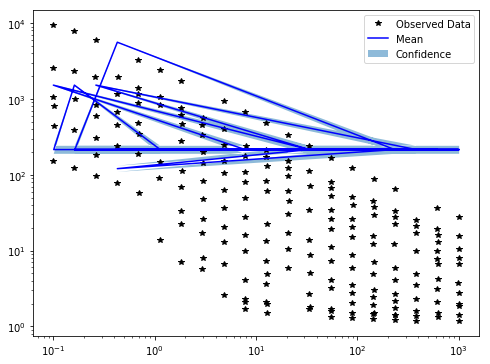

In [107]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.loglog(train_x.numpy()[:, 0], train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.loglog(test_x.numpy()[:, 0], observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy()[:, 0], lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])